# pre-check

1. set up your own working directory. 
2. make sure the packages are installed: `RColorBrewer`, `ggplot2`, `dplyr`, `pheatmap`, `tibble`, `tidyr`, `amap`, `org.Hs.eg.db`, `clusterProfiler`, `enrichplot`, `ReactomePA`, `UpSetR`, `data.table`
3. make sure the following input files are inside:
    - `pr.tsv`: original Taiji output file
    - `meta.csv`: meta data with cell type, disease state
    - `mycolors.rds`: color palette for meta data
    - `hclust_order_by_kmeans_hp.txt`: custom order of pseudobulk clusters
4. scripts are inside:
    - `findOptimal.R`: find optimal hyper-parameters for Kmeans clustering
    - `specificTFs_cell.R`: identify Kmeans group-specific TFs. Dependencies are `unpairedtTest.R`, `wilcoxonTest.R`
    - `utils.R`: some basic functions
    - `gsea.R`: GO analysis

In [1]:
# set working directory
maindir <- "/home/jupyter/paper_figures/" # needs to be modified
setwd(maindir)

In [11]:
# import functions
source('findOptimal.R')
source('specificTFs_cell.R')
source('utils.R')
source('gsea.R')

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



In [3]:
# import libraries
library(RColorBrewer)
library(ggplot2)
library(dplyr)
library(pheatmap)
library(data.table)


Attaching package: ‘dplyr’


The following object is masked from ‘package:AnnotationDbi’:

    select


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:IRanges’:

    shift


The following objects are masked from ‘package:S4Vectors’:

    first, second




In [4]:
# set plot parameters, which is suitable for CNS publication
plot.format = theme(
    plot.background=element_blank(),
    panel.grid=element_blank(),
    panel.background=element_blank(),
    panel.border=element_rect(color="black", linewidth=0.5, fill=NA),
    axis.line=element_blank(),
    axis.ticks=element_line(color="black",linewidth=0.5),
    axis.text=element_text(color="black", size=7),
    axis.title=element_text(color="black", size=7),
    plot.title=element_text(color="black", size=7),
    legend.background=element_blank(),
    legend.key=element_blank(),
    legend.text=element_text(color="black", size=7),
    legend.title=element_text(color="black", size=7))

In [5]:
# set cell types of interest
selected_cell_states <- c("B memory", "B naive", "CD14 Mono", "CD16 Mono","CD4 Naive","CD8 Naive","CD4 TCM","CD8 TEM","MAIT","NK","Treg")

In [56]:
# prepare input
pr <- read.csv('pr.tsv', sep='\t')
pr_normed <- scaleData(pr) ## normalize data across rows to make sure the values is in range [0,1] after norm
pr_normed2 <- zscore(pr) ## zscore of pagerank row-wise
mycolors <- readRDS('mycolors.rds')
meta <- read.table('meta.csv', row.names = 1)
col_orders <- readLines('hclust_order_by_kmeans_hp.txt') ## hclust order of clusters for heatmap

# Kmeans clustering

The following inputs are needed for Kmeans clustering:
1. PageRank scores matrix, which is the output of Taiji. Each row is one TF, each column is one sample, and each cell is PageRank score. 
2. meta data of each sample. Typical meta data includes cell types, participant id, clinical status, etc.

## PCA reduction

The first step is to prepare data for Kmeans clustering. Since we have too many dimensions for each sample, we need to perform PCA for dimension reduction. In the meantime, we can also visualize the first principal components (PCs) to check whether they're associated with meta data, like cell lineages or disease state.

In [7]:
# load data first
tag <- "pr_normed"
data <- pr_normed

dim(data)
head(data)

[1] 1078 1613

,B001_PB00001_C1,B001_PB00001_C2,B001_PB00001_C3,B001_PB00001_C4,B001_PB00001_C5,B001_PB00001_C6,B001_PB00001_C7,B001_PB00001_C8,B001_PB00001_C9,B001_PB00001_C10,⋯,B131_PB00369_C10,B131_PB00369_C12,B131_PB00369_C13,B131_PB00369_C14,B131_PB00369_C15,B131_PB00369_C16,B131_PB00369_C17,B131_PB00369_C18,B131_PB00369_C19,B131_PB00369_C20
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AC023509.3,8.556566e-02,5.448897e-02,1.585584e-02,1.311782e-01,1.135816e-01,0.0854806984,0.1061443300,3.280148e-02,0.1036893307,1.517231e-01,⋯,0.1593307746,0.0894206520,0.1754979104,0.1438675339,0.2458939987,0.2704650023,0.2189180898,3.037025e-01,0.3947879119,0.1354950666
AHR,3.517425e-01,1.121216e-01,6.578109e-02,1.012568e-01,4.391448e-01,0.1791959601,0.1997726606,7.205553e-02,0.1211216209,8.253573e-02,⋯,0.1954586111,0.1136821425,0.1152027196,0.3164520151,0.0271536790,0.0485719120,0.2126857644,1.137838e-01,0.0887658740,0.0880089694
AIRE,1.952430e-02,3.301379e-03,4.698693e-02,3.567670e-03,5.832853e-03,0.1610461691,0.3879323691,1.171336e-02,0.0218164533,4.087295e-02,⋯,0.0759665550,0.2684431079,0.0298219108,0.0262929859,0.0244119109,0.0456023830,0.1140375214,6.432672e-03,0.0281817144,0.0962011260
ALX3,3.028683e-02,3.355990e-02,6.358329e-02,5.412127e-02,6.609720e-02,0.0568541965,0.0512760631,2.855552e-02,0.0557415844,1.446260e-02,⋯,0.0538735792,0.0554536815,0.0713904668,0.0644166278,0.0691312942,0.0933417576,0.0769246921,2.243454e-02,0.0905992280,0.0599064053
ALX4,4.346851e-06,2.266672e-05,2.718526e-05,2.824531e-05,3.822283e-05,0.0001566324,0.0000988717,8.008034e-05,0.0001413576,3.785668e-05,⋯,0.0004889063,0.0001224134,0.0002014525,0.0001831357,0.0001655732,0.0002462116,0.0002222999,5.253931e-05,0.0002085679,0.0001401174
AR,4.819389e-02,4.230149e-02,6.323270e-03,1.592834e-02,8.358752e-02,0.0788520206,0.0858211421,2.176034e-02,0.0603889957,1.515899e-02,⋯,0.0517006257,0.0367981485,0.0560689724,0.0591622436,0.0848250982,0.0962661641,0.0665928773,1.922661e-02,0.0747289018,0.0490361479


In [8]:
# perform pca
pca <- data %>% as.matrix %>% t %>% prcomp 
percentVar <- pca$sdev^2 / sum( pca$sdev^2 )

# visualize first PCs
mydata <- pca %>% .$x %>% data.frame %>% mutate(Samples = rownames(.)) %>% 
    mutate(cell.type = meta[match(rownames(.), meta$id),"preClust"]) %>% 
    mutate(subject.group = meta[match(rownames(.), meta$id),"subject.group3"])

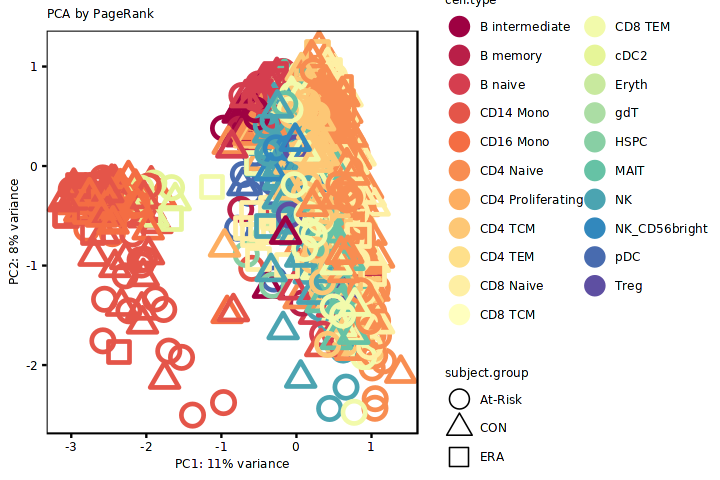

In [9]:
options(repr.plot.width=6, repr.plot.height=4)
myPlot <- ggplot(mydata, aes(x = PC1, y = PC2, colour = cell.type, shape=subject.group, stroke=1.5)) + geom_point(size = 5) + scale_color_manual(values = mycolors$cell.type) + 
        plot.format + scale_shape(solid = FALSE) + ggtitle("PCA by PageRank") +
        xlab(paste0("PC1: ",round(percentVar[1] * 100),"% variance")) +
        ylab(paste0("PC2: ",round(percentVar[2] * 100),"% variance"))
print(myPlot)

In [89]:
pdf(paste0("PCA_",tag,"_PC1_2_group3.pdf"), width = 7, height = 5)
print(myPlot)
dev.off()

png 
  2

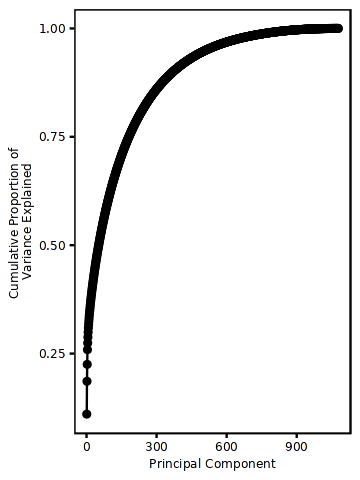

In [10]:
# plot pca cumulating variance
options(repr.plot.width=3, repr.plot.height=4)
df2 <- data.frame(x=c(1:length(pca$sdev)),y=cumsum(percentVar))
p2 <- ggplot(df2)+aes(x=x,y=y)+geom_point()+geom_line()+
    labs(x="Principal Component",y="Cumulative Proportion of \nVariance Explained")+
    plot.format
print(p2)

In [92]:
## save to file
pdf(paste0("PCA_",tag,"_cumul_variance.pdf"), width=2, height=2)
print(p2)
dev.off()

png 
  2

## hyperparams selection

After manually checking the above cumulative PCA plot, we decide to use PC=300 to reduce the data based on "elbow" method, which explained 85% variance. Then we need to determine the best distance metric and number of K for Kmeans clustering. To evaluate the clustering quality, we computed the **average silhouette width** which combines both *cohesion* (how close data points in a cluster are to each other) and *separation* (how distinct a cluster is from other clusters). A higher silhouette width value indicates better clustering quality.

We used five common distance metrics:
- Euclidean distance
- Manhattan distance
- Kendall correlation
- Pearson correlation
- Spearman correlation

Number of k is selected from the range [3, 20]. The lower limit is considering the number of disease states while the upper limit is the balance of searching space and searching speed.

In [57]:
PCNo <- 300
df <- data %>% as.matrix %>% t
data_reduced <- as.data.frame(prcomp(df, rank. = PCNo)$x)

In [91]:
# this step takes ~20min
df2 <- findOptimal(data_reduced, max_k = 20)

ERROR: Error in findOptimal(data_reduced, max_k = 20): could not find function "findOptimal"


In [80]:
# save to file
write.csv(df2, 'kmeans_param.csv')

Warning message:
“Removed 10 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 10 rows containing missing values (`geom_point()`).”


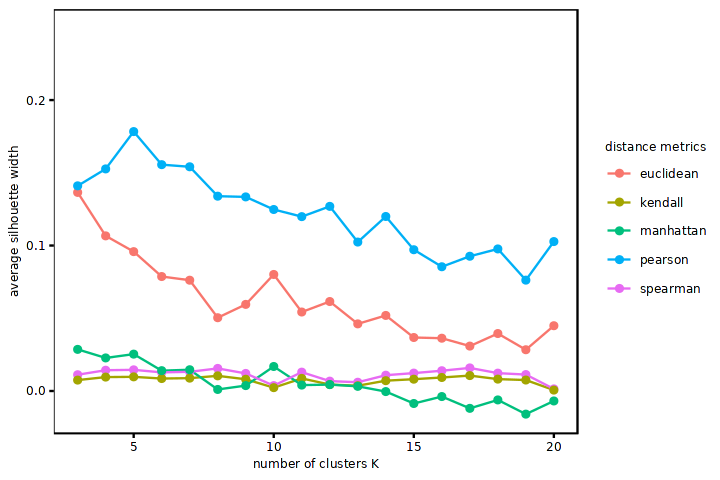

In [103]:
options(repr.plot.width=6, height=2)
p2 <- ggplot(df2)+aes(x=clusters,y=y,color=method,group=method)+
    geom_line()+geom_point()+xlim(3,20)+
    labs(x='number of groups K',y='average silhouette width',color='distance metrics')+plot.format
print(p2)

In [108]:
# save to file
pdf("kmeans_param.pdf",width=3.5,height = 2)
print(p2)
dev.off()

Warning message:
“Removed 10 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 10 rows containing missing values (`geom_point()`).”


png 
  2

## Kmeans clustering

From the distance metrics plot, we can select the best hyperparam combos: 
- K=5
- distance metric=Pearson Correlation.

You need to install package `amap`

In [58]:
PCNo <- 300
data <- pr_normed2
df <- data %>% as.matrix %>% t
data_reduced <- as.data.frame(prcomp(df, rank. = PCNo)$x)

In [60]:
# get final Kmeans clustering result
set.seed(42)
clusterNo <- 5
Cluster <- amap::Kmeans(data_reduced, centers = clusterNo, nstart = 25,iter.max = 50, method = "pearson")
df2 <- as.data.frame(Cluster$cluster) %>% tibble::rownames_to_column("id") %>% dplyr::rename(kmeans=`Cluster$cluster`) 
df2$kmeans <- paste0("G",df2$kmeans)

In [63]:
# get updated meta file
info <- meta %>% inner_join(df2, by = "id")
head(info)
dim(info)

,preClust,cluster,purity,cells,RNA_cells,ATAC_cells,sample,id,sample.visitName,subject.biologicalSex,⋯,cohort.cohortGuid,subject.age,sample.sampleKitGuid,sample.visitDetails,sample.daysSinceFirstVisit,subject.race,subject.group,subject.group2,subject.group3,kmeans
,<chr>,<chr>,<dbl>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,CD14 Mono,C1,0.940,5329,4327,1002,B001_PB00001,B001_PB00001_C1,Flu Year 1 Day 0,Female,⋯,BR1,36,KT00001,N/A - Flu-Series Timepoint Only,0,Caucasian,CON,CON,CON,G1
2,NK,C2,0.873,1946,1391,555,B001_PB00001,B001_PB00001_C2,Flu Year 1 Day 0,Female,⋯,BR1,36,KT00001,N/A - Flu-Series Timepoint Only,0,Caucasian,CON,CON,CON,G3
3,B naive,C3,0.946,1830,1511,319,B001_PB00001,B001_PB00001_C3,Flu Year 1 Day 0,Female,⋯,BR1,36,KT00001,N/A - Flu-Series Timepoint Only,0,Caucasian,CON,CON,CON,G5
4,MAIT,C4,0.840,1588,1200,388,B001_PB00001,B001_PB00001_C4,Flu Year 1 Day 0,Female,⋯,BR1,36,KT00001,N/A - Flu-Series Timepoint Only,0,Caucasian,CON,CON,CON,G3
5,CD16 Mono,C5,0.425,1062,392,670,B001_PB00001,B001_PB00001_C5,Flu Year 1 Day 0,Female,⋯,BR1,36,KT00001,N/A - Flu-Series Timepoint Only,0,Caucasian,CON,CON,CON,G1
6,CD4 TCM,C6,0.726,1059,104,955,B001_PB00001,B001_PB00001_C6,Flu Year 1 Day 0,Female,⋯,BR1,36,KT00001,N/A - Flu-Series Timepoint Only,0,Caucasian,CON,CON,CON,G2


[1] 1613   22

In [65]:
# save to file
write.csv(info, 'meta_kmeans_5.csv')

# cluster distribution across kmeans group

## cell type distribution across Kmeans groups

First, we checked the cell type distribution across kmeans groups

In [12]:
file <- 'meta_kmeans_5.csv'
test_group <- 'preClust'
f1 <- paste0("id ~ kmeans + ", test_group)
f2 <- paste0("id ~ ", test_group)


df1 <- read.csv(file) %>% 
    stats::aggregate(as.formula(f1), data = ., FUN = function(x){NROW(x)})

# add null distribtution
df2 <- read.csv(file) %>%
    stats::aggregate(as.formula(f2), data = ., FUN = function(x){NROW(x)}) %>% mutate(kmeans="All")
df3 <- rbind(df1,df2) %>% arrange(kmeans)

head(df3)
dim(df3)

,kmeans,preClust,id
,<chr>,<chr>,<int>
1,All,B intermediate,27
2,All,B memory,27
3,All,B naive,82
4,All,CD14 Mono,86
5,All,CD16 Mono,45
6,All,CD4 Naive,451


[1] 74  3

In [67]:
# write to file
tmp <- df3 %>% tidyr::pivot_wider(names_from = preClust, values_from = id, values_fill = 0) 
write.csv(tmp,'cell_states_freq_across_kmeans.csv',quote=F, row.names=F)

In [13]:
# normalize
df3 <- read.csv('cell_states_freq_across_kmeans.csv') %>% mutate(kmeans=sub('C','G',kmeans)) %>% tibble::column_to_rownames('kmeans') 
df4 <- df3/rowSums(df3)
head(df4)

,B.intermediate,B.memory,B.naive,CD14.Mono,CD16.Mono,CD4.Naive,CD4.Proliferating,CD4.TCM,CD4.TEM,CD8.Naive,⋯,CD8.TEM,cDC2,Eryth,gdT,HSPC,MAIT,NK,NK_CD56bright,pDC,Treg
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
All,0.016738996,0.016738996,0.050836950,0.053316801,0.027898326,0.279603224,0.006199628,0.218846869,0.001239926,0.06261624,⋯,0.101053937,0.005579665,0.001239926,0.001859888,0.001239926,0.03471792,0.09547427,0.013019219,0.004959702,0.006199628
G1,0.000000000,0.000000000,0.000000000,0.547297297,0.297297297,0.027027027,0.013513514,0.006756757,0.000000000,0.03378378,⋯,0.006756757,0.060810811,0.000000000,0.000000000,0.000000000,0.00000000,0.00000000,0.000000000,0.006756757,0.000000000
G2,0.002197802,0.006593407,0.015384615,0.006593407,0.002197802,0.336263736,0.008791209,0.224175824,0.000000000,0.09450549,⋯,0.138461538,0.000000000,0.004395604,0.000000000,0.004395604,0.04615385,0.09010989,0.006593407,0.002197802,0.008791209
G3,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.007142857,0.007142857,0.039285714,0.003571429,0.00000000,⋯,0.342857143,0.000000000,0.000000000,0.003571429,0.000000000,0.12500000,0.40357143,0.064285714,0.000000000,0.003571429
G4,0.000000000,0.000000000,0.001683502,0.000000000,0.000000000,0.491582492,0.001683502,0.397306397,0.001683502,0.08922559,⋯,0.005050505,0.000000000,0.000000000,0.003367003,0.000000000,0.00000000,0.00000000,0.000000000,0.000000000,0.008417508
G5,0.191176471,0.176470588,0.544117647,0.014705882,0.000000000,0.000000000,0.007352941,0.022058824,0.000000000,0.00000000,⋯,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.00000000,0.00000000,0.000000000,0.044117647,0.000000000


We can see that G2 has cell type distribution similar to the overall PBMC distribution and included all 11 major cell types.

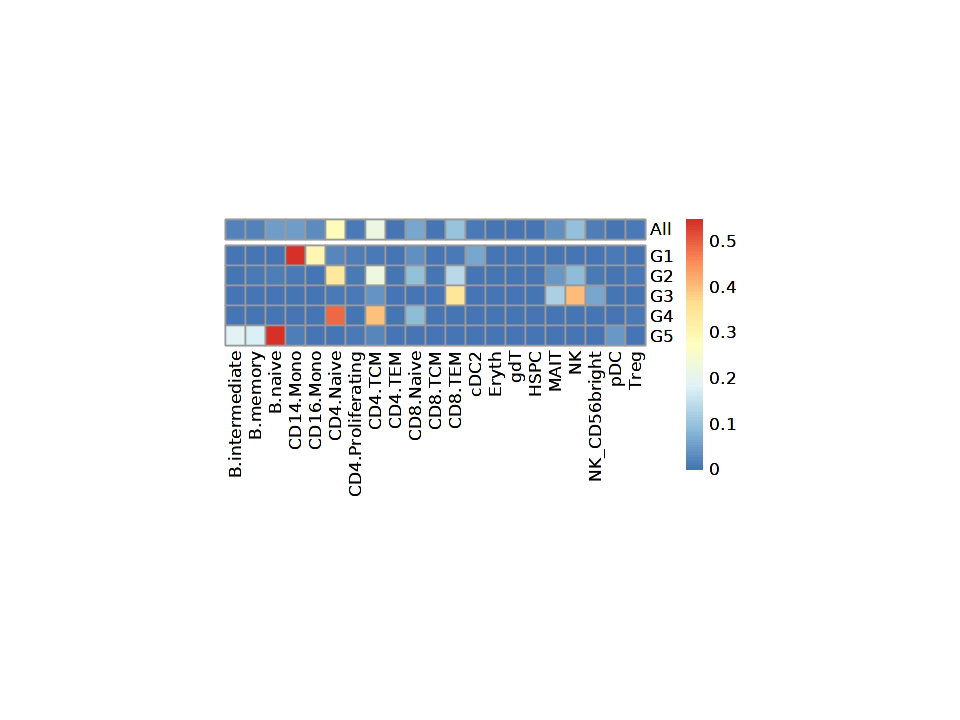

In [14]:
# visualize all cell types
options(repr.plot.width=8, repr.plot.height=6)
library(pheatmap)
p <- pheatmap(df4, cluster_rows=FALSE, cluster_cols=FALSE, gaps_row = 1, cellheight = 12, cellwidth = 12, angle_col = 90)
print(p)

 [1] "B memory"  "B naive"   "CD14 Mono" "CD16 Mono" "CD4 Naive" "CD8 Naive"
 [7] "CD4 TCM"   "CD8 TEM"   "MAIT"      "NK"        "Treg"     


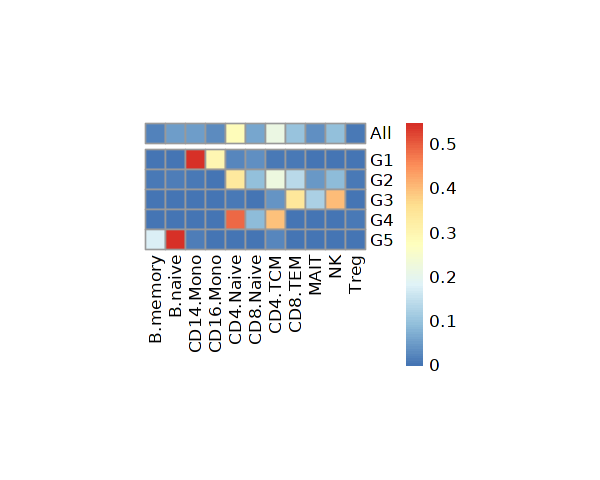

In [15]:
# select major cell states and visualize
options(repr.plot.width=5, repr.plot.height=4)
print(selected_cell_states)
df5 <- df4[,sub(' ','.',selected_cell_states)]

p <- pheatmap(df5, cluster_rows=FALSE, cluster_cols=FALSE, gaps_row = 1, cellheight = 12, cellwidth = 12, angle_col=90)

## At-Risk/ERA vs CON ratio across kmeans groups

Next, we investigated the disease state distribution across 5 kmeans groups. We want to see if At-Risk/ERA is significantly enriched in any Kmeans group.

In [16]:
file <- 'meta_kmeans_5.csv'
test_group <- 'subject.group2'
f1 <- paste0("id ~ kmeans + ", test_group)
f2 <- paste0("id ~ ", test_group)


df1 <- read.csv(file) %>% 
    stats::aggregate(as.formula(f1), data = ., FUN = function(x){NROW(x)})

# add null distribtution
df2 <- read.csv(file) %>%
    stats::aggregate(as.formula(f2), data = ., FUN = function(x){NROW(x)}) %>% mutate(kmeans="All")
df3 <- rbind(df1,df2) %>% arrange(kmeans)

head(df3)
dim(df3)

,kmeans,subject.group2,id
,<chr>,<chr>,<int>
1,All,At-Risk/ERA,753
2,All,CON,860
3,G1,At-Risk/ERA,70
4,G1,CON,78
5,G2,At-Risk/ERA,261
6,G2,CON,194


[1] 12  3

In [73]:
# write to file
tmp <- df3 %>% tidyr::pivot_wider(names_from = subject.group2, values_from = id, values_fill = 0) 
write.csv(tmp,'disease_state_freq_across_kmeans.csv',quote=F, row.names=F)

In [17]:
L <- unique(df3$kmeans)
ratios <- data.frame("ratio"= unlist(lapply(L, function(x) df3[df3$kmeans==x & df3$subject.group2=="At-Risk/ERA", "id"]/df3[df3$kmeans==x & df3$subject.group2=="CON", "id"])), "kmeans"=L) 
null = ratios[ratios$kmeans=='All','ratio']
ratios$adjusted.ratio <- ratios$ratio/null
ratios

ratio,kmeans,adjusted.ratio
<dbl>,<chr>,<dbl>
0.8755814,All,1.0000000
0.8974359,G1,1.0249600
1.3453608,G2,1.5365343
0.8300654,G3,0.9480162
0.5967742,G4,0.6815748
1.1587302,G5,1.3233837


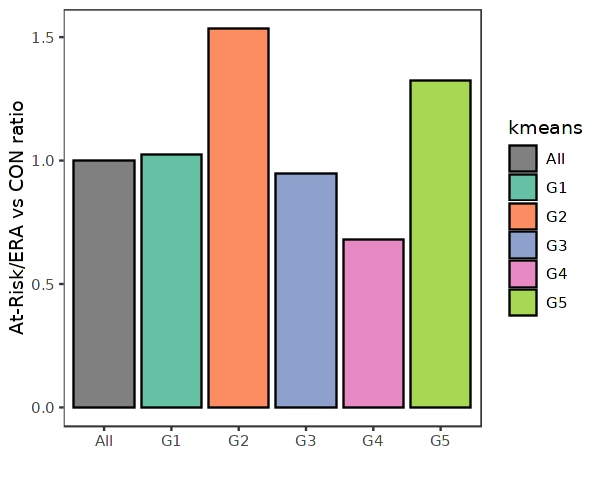

In [18]:
p4 <- ggplot(ratios, aes(x = kmeans, y = adjusted.ratio, fill=kmeans)) +
    geom_bar(stat = "identity", colour = "black") +
    labs(x = "", y = "At-Risk/ERA vs CON ratio") + 
    scale_fill_manual(values = c("#808080",brewer.pal(5,"Set2")[1:5])) +
    theme_bw() +
    theme(
      panel.grid.minor.x = element_blank(),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.y = element_blank(),
      panel.grid.major.y = element_blank()
    )
p4

### get statistical significance

From above plot, it's obvious that G2 is enriched in At-Risk/ERA compared to controls. Then we used chi-squared goodness of fit test to see if the enrichment is significant or not compared to the null distribution. R function `chisq.test` can be used as follow:
`chisq.test(x,p)`, where x is a numeric vector representing the observed probability and p represents the expected probability.

In [19]:
# test for G2
a <- df3 |> filter(kmeans=='All' & subject.group2=='At-Risk/ERA') |> pull(id) 
b <- df3 |> filter(kmeans=='All' & subject.group2=='CON') |> pull(id) 
a2 <- df3 |> filter(kmeans=='G2' & subject.group2=='At-Risk/ERA') |> pull(id) 
b2 <- df3 |> filter(kmeans=='G2' & subject.group2=='CON') |> pull(id) 

x <- c(a2,b2)
p <- c(a/(a+b), b/(a+b))
chisq.test(x,p=p)


	Chi-squared test for given probabilities

data:  x
X-squared = 20.849, df = 1, p-value = 4.97e-06


## G2 clusters ratio per cell type in CON and At-Risk/ERA

From the previous analysis, we already know:
- G2 is significantly enriched in At-Risk/ERA
- G2 is multi-lineage group

We then want to see the distribution of the enrichment across cell types. In other words, what cell types in G2 that contributed more in the enrichment?

In [20]:
C_target = 'G2'
g <- "subject.group2"
meta3 <- read.csv("meta_kmeans_5.csv", row.names = 1) %>% 
        mutate(preClust2 = ifelse(preClust %in% c("B memory", "B naive", "B intermediate"), "B cell", ifelse(preClust %in% c("CD16 Mono", "CD14 Mono"), "Monocytes", preClust)),
                kmeans2 = ifelse(kmeans==C_target, kmeans, "other"))
head(meta3)
dim(meta3)

,preClust,cluster,purity,cells,RNA_cells,ATAC_cells,sample,id,sample.visitName,subject.biologicalSex,⋯,sample.sampleKitGuid,sample.visitDetails,sample.daysSinceFirstVisit,subject.race,subject.group,subject.group2,subject.group3,kmeans,preClust2,kmeans2
,<chr>,<chr>,<dbl>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,CD14 Mono,C1,0.940,5329,4327,1002,B001_PB00001,B001_PB00001_C1,Flu Year 1 Day 0,Female,⋯,KT00001,N/A - Flu-Series Timepoint Only,0,Caucasian,CON,CON,CON,G1,Monocytes,other
2,NK,C2,0.873,1946,1391,555,B001_PB00001,B001_PB00001_C2,Flu Year 1 Day 0,Female,⋯,KT00001,N/A - Flu-Series Timepoint Only,0,Caucasian,CON,CON,CON,G3,NK,other
3,B naive,C3,0.946,1830,1511,319,B001_PB00001,B001_PB00001_C3,Flu Year 1 Day 0,Female,⋯,KT00001,N/A - Flu-Series Timepoint Only,0,Caucasian,CON,CON,CON,G5,B cell,other
4,MAIT,C4,0.840,1588,1200,388,B001_PB00001,B001_PB00001_C4,Flu Year 1 Day 0,Female,⋯,KT00001,N/A - Flu-Series Timepoint Only,0,Caucasian,CON,CON,CON,G3,MAIT,other
5,CD16 Mono,C5,0.425,1062,392,670,B001_PB00001,B001_PB00001_C5,Flu Year 1 Day 0,Female,⋯,KT00001,N/A - Flu-Series Timepoint Only,0,Caucasian,CON,CON,CON,G1,Monocytes,other
6,CD4 TCM,C6,0.726,1059,104,955,B001_PB00001,B001_PB00001_C6,Flu Year 1 Day 0,Female,⋯,KT00001,N/A - Flu-Series Timepoint Only,0,Caucasian,CON,CON,CON,G2,CD4 TCM,G2


[1] 1613   24

In [21]:
# get the number of total clusters across cell types
total <- meta3 |> group_by(preClust2, !!as.name(g)) |> summarise(total=n())
head(total)
dim(total)

# get the number of G2 clusters across cell types
sub <- meta3 |> filter(kmeans==C_target) |> group_by(preClust2, !!as.name(g)) |> summarise(sub=n())
head(sub)
dim(sub)

`summarise()` has grouped output by 'preClust2'. You can override using the
`.groups` argument.


preClust2,subject.group2,total
<chr>,<chr>,<int>
B cell,At-Risk/ERA,71
B cell,CON,65
CD4 Naive,At-Risk/ERA,202
CD4 Naive,CON,249
CD4 Proliferating,CON,10
CD4 TCM,At-Risk/ERA,159


[1] 31  3

`summarise()` has grouped output by 'preClust2'. You can override using the
`.groups` argument.


preClust2,subject.group2,sub
<chr>,<chr>,<int>
B cell,At-Risk/ERA,5
B cell,CON,6
CD4 Naive,At-Risk/ERA,94
CD4 Naive,CON,59
CD4 Proliferating,CON,4
CD4 TCM,At-Risk/ERA,60


[1] 24  3

In [22]:
# calculate the percentage of G2 clusters per cell type in CON and At-Risk/ERA respectively
df <- sub %>% right_join(total, by=c("preClust2",g)) %>% mutate_all(~replace(., is.na(.), 0)) %>% mutate(pct = 100*sub/total) %>%
            mutate(label=paste0(sub,"(", sprintf("%.0f", pct), "%)"))
head(df)
dim(df)

`mutate_all()` ignored the following grouping variables:
• Column `preClust2`
ℹ Use `mutate_at(df, vars(-group_cols()), myoperation)` to silence the message.


preClust2,subject.group2,sub,total,pct,label
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
B cell,At-Risk/ERA,5,71,7.042254,5(7%)
B cell,CON,6,65,9.230769,6(9%)
CD4 Naive,At-Risk/ERA,94,202,46.534653,94(47%)
CD4 Naive,CON,59,249,23.694779,59(24%)
CD4 Proliferating,CON,4,10,40.000000,4(40%)
CD4 TCM,At-Risk/ERA,60,159,37.735849,60(38%)


[1] 31  6

In [ ]:
# save to file
write.csv(df, 'pct_G2_per_cell_type_two_groups.csv')

### statistical significance

We used chi-squared goodness of fit test to see if the percentage is significant different from CON and At-Risk/ERA. 

In [23]:
selected_cell_states2 <- c('B cell', 'Monocytes', 'CD4 Naive', 'CD8 Naive', 'CD4 TCM', 'CD8 TEM', 'MAIT', 'NK', 'Treg')
selected_cell_states2

[1] "B cell"    "Monocytes" "CD4 Naive" "CD8 Naive" "CD4 TCM"   "CD8 TEM"  
[7] "MAIT"      "NK"        "Treg"

In [24]:
df %>% filter(preClust2=='MAIT')

preClust2,subject.group2,sub,total,pct,label
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
MAIT,CON,21,43,48.83721,21(49%)
MAIT,At-Risk/ERA,0,13,0.00000,0(0%)


In [25]:
#### calculate p-values for all cell types
pvalues <- lapply(selected_cell_states2, function(x){
    tmp <- df %>% filter(preClust2==x) 
    a <- tmp |> filter(subject.group2=='At-Risk/ERA') |> pull(total)
    b <- tmp |> filter(subject.group2=='CON') |> pull(total)
    c <- tmp |> filter(subject.group2=='At-Risk/ERA') |> pull(sub)
    d <- tmp |> filter(subject.group2=='CON') |> pull(sub)
    
    null.prop <- c(a/(a + b), b/(a + b))
    res <- chisq.test(c(c, d), p = null.prop)
    print(x)
    print(res$p.value)    
    return(res$p.value)
})

[1] "B cell"
[1] 0.6539587


Warning message in chisq.test(c(c, d), p = null.prop):
“Chi-squared approximation may be incorrect”


[1] "Monocytes"
[1] 0.8419046
[1] "CD4 Naive"
[1] 3.455345e-05
[1] "CD8 Naive"
[1] 0.02806609
[1] "CD4 TCM"
[1] 0.005151296
[1] "CD8 TEM"
[1] 0.1460054


Warning message in chisq.test(c(c, d), p = null.prop):
“Chi-squared approximation may be incorrect”


[1] "MAIT"
[1] 0.01174583
[1] "NK"
[1] 0.2742988


Warning message in chisq.test(c(c, d), p = null.prop):
“Chi-squared approximation may be incorrect”


[1] "Treg"
[1] 0.5402914


In [26]:
names(pvalues) <- selected_cell_states2

In [27]:
## select cell lineages with significant enrichment
cells <- names(pvalues)[which(pvalues <= 0.2)]

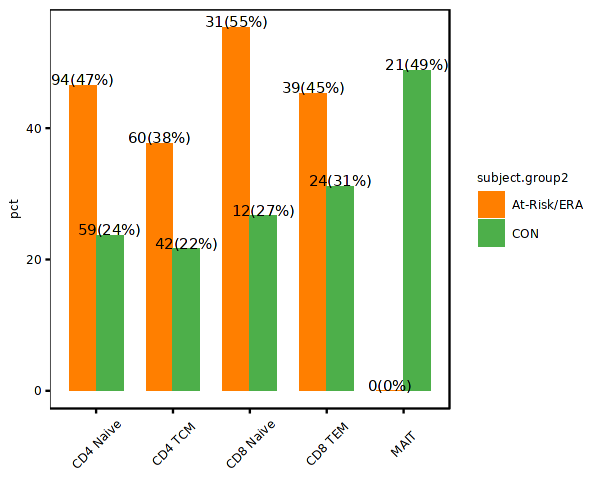

In [28]:
## plot vertical histogram
df2 <- df %>% filter(preClust2 %in% cells)
p <- ggplot(df2, aes(x = preClust2, y = pct, fill = !!as.name(g))) + 
    geom_bar(position = position_dodge(), stat = "identity", width = .7) +
    scale_fill_manual(values = mycolors[[g]]) + 
    geom_text(aes(label = label), position = position_dodge(width = .7), vjust=0, size = 3) +
    plot.format + theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust = 0.5), axis.title.x = element_blank())
p

# signature TFs, genes, pathways

## Kmeans group specific TFs

The heatmap shows distinct TF profiles across Kmeans groups. We used Wilcoxon rank-sum test (a.k.a Mann-Whitney U test) to identify Kmeans group-specific TFs. We selected Wilcoxon test because our data doesn't fit normal distribution. If data is normally or log-normally distributed, t-test can be applied here as well.

To be more specific, we divided the clusters into two groups: target group and background group. Target group included the clusters in the Kmeans group of interest, for example G2. Background group included all the remaining clusters. We experimented on several combinations of p-value and log2 fold change. We chose p-value of 0.01 and log2FC of 0.5 considering a reasonable number of TFs for all 5 groups. 

In [90]:
# create dir for results
dir.create(file.path(maindir, 'kmeans/'), showWarnings = FALSE)
dir.create(file.path(maindir, 'kmeans/GO/'), showWarnings = FALSE)

In [342]:
setwd(paste0(maindir,"kmeans/"))

In [200]:
## identify kmeans cluster-specific TFs
main <- function(p = 0.001, d = 1, data=pr, meta=meta2, group_by='kmeans'){
    tryCatch({
        subject.types <- unique(meta[[group_by]])
        ls <- lapply(subject.types,function(y) 
          specificTFs_cell(y, p = p, d = d, df = data, group = meta, group_name = group_by, test = "wilcoxon"))

        ### GO analysis
        L <- list.files(path = "./", pattern = paste0(".*_p",p,"_d",d,".*.txt"), full.names = T)
        print(L)
        lapply(L, function(x) gsea(x, output_dir = "GO/", showCategory = 20, go.height = 10, go.width = 7))
    },error=function(e){})

}                     

In [29]:
# load data and meta data
meta2 <- read.csv(paste0(maindir,"/meta_kmeans_5.csv"), row.names = 1)
head(meta2)
dim(meta2)

,preClust,cluster,purity,cells,RNA_cells,ATAC_cells,sample,id,sample.visitName,subject.biologicalSex,⋯,cohort.cohortGuid,subject.age,sample.sampleKitGuid,sample.visitDetails,sample.daysSinceFirstVisit,subject.race,subject.group,subject.group2,subject.group3,kmeans
,<chr>,<chr>,<dbl>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,CD14 Mono,C1,0.940,5329,4327,1002,B001_PB00001,B001_PB00001_C1,Flu Year 1 Day 0,Female,⋯,BR1,36,KT00001,N/A - Flu-Series Timepoint Only,0,Caucasian,CON,CON,CON,G1
2,NK,C2,0.873,1946,1391,555,B001_PB00001,B001_PB00001_C2,Flu Year 1 Day 0,Female,⋯,BR1,36,KT00001,N/A - Flu-Series Timepoint Only,0,Caucasian,CON,CON,CON,G3
3,B naive,C3,0.946,1830,1511,319,B001_PB00001,B001_PB00001_C3,Flu Year 1 Day 0,Female,⋯,BR1,36,KT00001,N/A - Flu-Series Timepoint Only,0,Caucasian,CON,CON,CON,G5
4,MAIT,C4,0.840,1588,1200,388,B001_PB00001,B001_PB00001_C4,Flu Year 1 Day 0,Female,⋯,BR1,36,KT00001,N/A - Flu-Series Timepoint Only,0,Caucasian,CON,CON,CON,G3
5,CD16 Mono,C5,0.425,1062,392,670,B001_PB00001,B001_PB00001_C5,Flu Year 1 Day 0,Female,⋯,BR1,36,KT00001,N/A - Flu-Series Timepoint Only,0,Caucasian,CON,CON,CON,G1
6,CD4 TCM,C6,0.726,1059,104,955,B001_PB00001,B001_PB00001_C6,Flu Year 1 Day 0,Female,⋯,BR1,36,KT00001,N/A - Flu-Series Timepoint Only,0,Caucasian,CON,CON,CON,G2


[1] 1613   22

In [115]:
# this step takes several minutes
main(data=pr, meta=meta2, p = 0.01, d = 0.5)

[1] 148
[1] 280
[1] 136
[1] 455
[1] 594
[1] ".//G1_p0.01_d0.5_gene136_wilcoxon.txt"
[2] ".//G2_p0.01_d0.5_gene433_wilcoxon.txt"
[3] ".//G3_p0.01_d0.5_gene63_wilcoxon.txt" 
[4] ".//G4_p0.01_d0.5_gene37_wilcoxon.txt" 
[5] ".//G5_p0.01_d0.5_gene95_wilcoxon.txt" 


'select()' returned 1:1 mapping between keys and columns

Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns



[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

### TF overlap

In [30]:
library(UpSetR)

In [31]:
L <- list.files(path = paste0(maindir, '/kmeans/'),pattern = "G.*p0.01_d0.5.*txt", full.names = T)
TFs <- lapply(L, function(x) readLines(x))
names(TFs) <- paste0("G",1:5)

In [32]:
p <- upset(fromList(TFs), 
      nintersects = 40, 
      nsets = 5, 
      order.by = "freq", 
      decreasing = T, 
      mb.ratio = c(0.6, 0.4),
      number.angles = 0, 
      text.scale = 1.1, 
      point.size = 2.8, 
      line.size = 1
      )

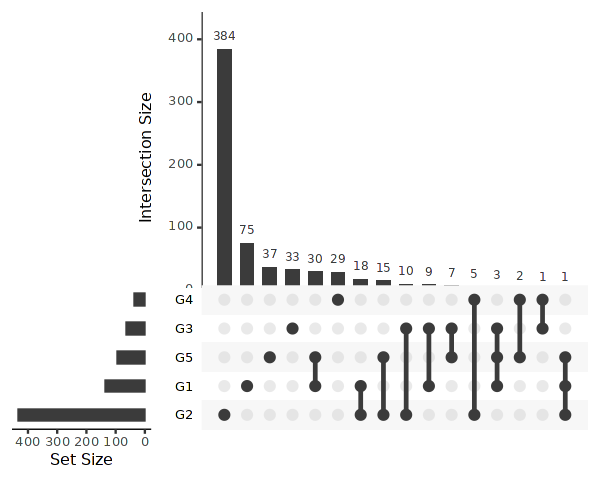

In [33]:
print(p)

In [347]:
pdf('kmeans_group_TFs_upset.pdf', width = 4, height = 4)
print(p)
dev.off()

png 
  2

## Kmeans group specific pathways

We already performed gene set enrichment analysis for each Kmeans group TFs. We'll gather the results and visualize the top pathways.

In [34]:
L <- list.files(path = paste0(maindir, '/kmeans/GO/') , pattern = 'p0.01_d0.5.*csv', full.names = T)
L

[1] "/home/jupyter/paper_figures//kmeans/GO//G1_p0.01_d0.5_gene136_wilcoxon_GO.csv"
[2] "/home/jupyter/paper_figures//kmeans/GO//G2_p0.01_d0.5_gene433_wilcoxon_GO.csv"
[3] "/home/jupyter/paper_figures//kmeans/GO//G3_p0.01_d0.5_gene63_wilcoxon_GO.csv" 
[4] "/home/jupyter/paper_figures//kmeans/GO//G4_p0.01_d0.5_gene37_wilcoxon_GO.csv" 
[5] "/home/jupyter/paper_figures//kmeans/GO//G5_p0.01_d0.5_gene95_wilcoxon_GO.csv"

In [35]:
df <- do.call("rbind", lapply(L, function(x){read.csv(x) %>% filter(grepl('R-HSA', ID) & p.adjust<=0.05) %>% slice_min(order_by = p.adjust, n=20)%>%mutate(group=gsub('_.*','',gsub('.*/','',x)))}))
df$GeneRatio <- sapply(df$GeneRatio, function(x) eval(parse(text=x)))
df <- df %>% arrange(group, GeneRatio)
df$Description <- factor(df$Description, levels = unique(df$Description))
 
dim(df)
head(df)

[1] 67 10

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,group
,<chr>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
1,R-HSA-380994,ATF4 activates genes in response to endoplasmic reticulum stress,0.03658537,27/10899,1.053986e-03,0.0126478344,8.653781e-03,CEBPB/ATF3/CEBPG,3,G1
2,R-HSA-9648895,Response of EIF2AK1 (HRI) to heme deficiency,0.04878049,15/10899,3.814380e-06,0.0001017168,6.959571e-05,CEBPB/ATF3/ATF5/CEBPG,4,G1
3,R-HSA-525793,Myogenesis,0.04878049,30/10899,7.027746e-05,0.0010541619,7.212687e-04,MEF2C/MEF2A/MEF2D/TCF4,4,G1
4,R-HSA-2151201,Transcriptional activation of mitochondrial biogenesis,0.06097561,56/10899,6.026766e-05,0.0009642826,6.597723e-04,RXRA/ESRRA/MEF2C/MEF2D/PPARA,5,G1
5,R-HSA-9707564,Cytoprotection by HMOX1,0.06097561,64/10899,1.147728e-04,0.0016203215,1.108641e-03,RXRA/BACH1/NFE2L2/MAFK/PPARA,5,G1
6,R-HSA-400253,Circadian Clock,0.06097561,70/10899,1.758816e-04,0.0023450886,1.604534e-03,RXRA/NFIL3/MEF2C/MEF2D/PPARA,5,G1


This plot shows the top20 pathways for each Kmeans group. We curated a list of G2-specific pathways associated with RA pathogenesis:
1. Transcriptional regulation by RUNX2
2. YAP1- and WWTR1 (TAZ)-stimulated gene expression
3. SUMOylation of intracellular receptors
4. NOTCH3 Intracellular Domain Regulates Transcription
5. Deactivation of the beta-catenin transactivating complex

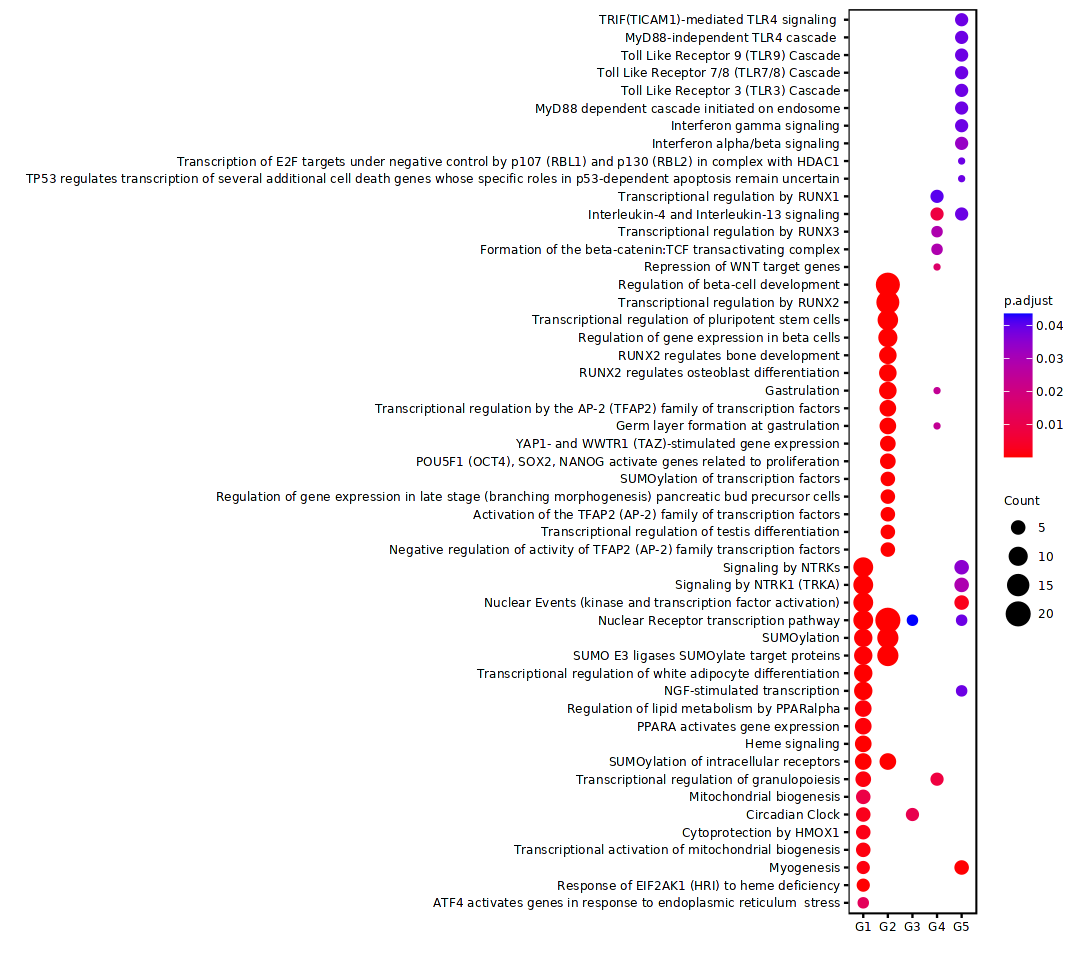

In [36]:
options(repr.plot.width = 9,repr.plot.height = 8)
p <- ggplot(df, aes(x=group, y=Description, size=Count, color=p.adjust))+
    geom_point()+scale_color_gradient(low="red",high="blue", name="p.adjust")+theme_bw()+
    ylab("")+xlab("")+plot.format
p

In [37]:
# selected representative pathways
# shortened version of plot
selected_pathways <- c('PPARA activates gene expression','Heme signaling','Mitochondrial biogenesis',
                       'SUMOylation of intracellular receptors','Transcriptional regulation by RUNX2','YAP1- and WWTR1 (TAZ)-stimulated gene expression','NOTCH3 Intracellular Domain Regulates Transcription','Deactivation of the beta-catenin transactivating complex',
                       'Circadian Clock',
                       'Formation of the beta-catenin:TCF transactivating complex','Repression of WNT target genes','Transcriptional regulation by RUNX3','Interleukin-4 and Interleukin-13 signaling',
                       'Interferon alpha/beta signaling','Toll Like Receptor 7/8 (TLR7/8) Cascade')
df2 <- df %>% filter(Description %in% selected_pathways)
df2$Description <- factor(df2$Description, levels =selected_pathways)
head(df2)
dim(df2)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,group
,<chr>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
1,R-HSA-400253,Circadian Clock,0.06097561,70/10899,1.758816e-04,2.345089e-03,1.604534e-03,RXRA/NFIL3/MEF2C/MEF2D/PPARA,5,G1
2,R-HSA-1592230,Mitochondrial biogenesis,0.06097561,95/10899,7.272260e-04,9.186013e-03,6.285167e-03,RXRA/ESRRA/MEF2C/MEF2D/PPARA,5,G1
3,R-HSA-4090294,SUMOylation of intracellular receptors,0.08536585,30/10899,1.861769e-09,8.936489e-08,6.114440e-08,RXRA/RARA/VDR/NR4A2/NR1H3/PPARA/PPARG,7,G1
4,R-HSA-9707616,Heme signaling,0.08536585,47/10899,5.190247e-08,1.557074e-06,1.065367e-06,RXRA/BACH1/MEF2C/NFE2L2/MAFK/MEF2D/PPARA,7,G1
5,R-HSA-1989781,PPARA activates gene expression,0.08536585,117/10899,2.682788e-05,5.365576e-04,3.671184e-04,RXRA/ESRRA/AHR/MTF1/NR1H3/PPARA/PPARG,7,G1
6,R-HSA-2032785,YAP1- and WWTR1 (TAZ)-stimulated gene expression,0.03703704,15/10899,4.404080e-08,6.966454e-07,5.057317e-07,NKX2-5/GATA4/TEAD4/TEAD1/TEAD2/TEAD3,6,G2


[1] 16 10

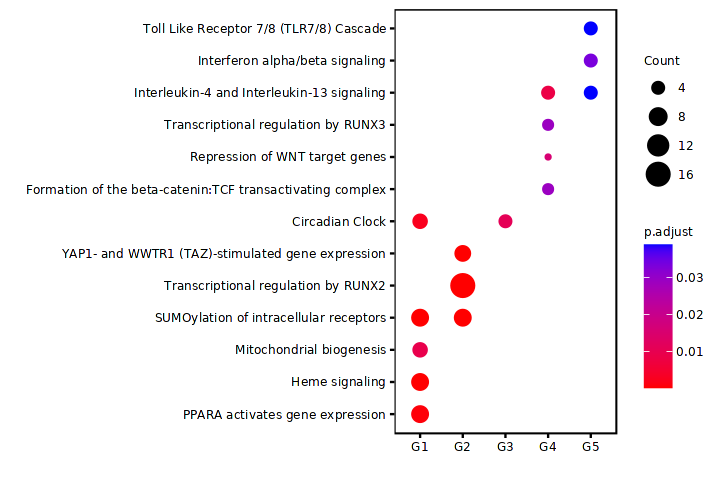

In [38]:
options(repr.plot.width = 6,repr.plot.height = 4)
p <- ggplot(df2, aes(x=group, y=Description, size=Count, color=p.adjust))+
    geom_point()+scale_color_gradient(low="red",high="blue", name="p.adjust")+theme_bw()+
    ylab("")+xlab("")+plot.format
p

In [355]:
# save to file
pdf('summary_representative_pathways.pdf', width = 6, height = 4)
print(p)
dev.off()

png 
  2

### signature pathways across cell types

Next, we identified G2-specific TFs along with pathways for each cell type. Target group included the G2 clusters in the cell type of interest and the background included the remaining clusters of the same cell type. p-value of 0.01 and log2 fold change of 0.5 were used for calling the specific TFs. 

In [189]:
# create dir for results
dir.create(file.path(maindir, 'kmeans_cell_type/'), showWarnings = FALSE)
dir.create(file.path(maindir, 'kmeans_cell_type/GO/'), showWarnings = FALSE)

In [39]:
setwd(paste0(maindir,'kmeans_cell_type/'))

In [213]:
meta3 <- meta2 |> mutate(preClust2 = ifelse(preClust %in% c("B memory", "B naive", "B intermediate"), "B cell", ifelse(preClust %in% c("CD16 Mono", "CD14 Mono"), "Monocytes", preClust))) |> mutate(cell_k=paste0(preClust2,'_',kmeans))
head(meta3)
dim(meta3)

,preClust,cluster,purity,cells,RNA_cells,ATAC_cells,sample,id,sample.visitName,subject.biologicalSex,⋯,sample.sampleKitGuid,sample.visitDetails,sample.daysSinceFirstVisit,subject.race,subject.group,subject.group2,subject.group3,kmeans,preClust2,cell_k
,<chr>,<chr>,<dbl>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,CD14 Mono,C1,0.940,5329,4327,1002,B001_PB00001,B001_PB00001_C1,Flu Year 1 Day 0,Female,⋯,KT00001,N/A - Flu-Series Timepoint Only,0,Caucasian,CON,CON,CON,G1,Monocytes,Monocytes_G1
2,NK,C2,0.873,1946,1391,555,B001_PB00001,B001_PB00001_C2,Flu Year 1 Day 0,Female,⋯,KT00001,N/A - Flu-Series Timepoint Only,0,Caucasian,CON,CON,CON,G3,NK,NK_G3
3,B naive,C3,0.946,1830,1511,319,B001_PB00001,B001_PB00001_C3,Flu Year 1 Day 0,Female,⋯,KT00001,N/A - Flu-Series Timepoint Only,0,Caucasian,CON,CON,CON,G5,B cell,B cell_G5
4,MAIT,C4,0.840,1588,1200,388,B001_PB00001,B001_PB00001_C4,Flu Year 1 Day 0,Female,⋯,KT00001,N/A - Flu-Series Timepoint Only,0,Caucasian,CON,CON,CON,G3,MAIT,MAIT_G3
5,CD16 Mono,C5,0.425,1062,392,670,B001_PB00001,B001_PB00001_C5,Flu Year 1 Day 0,Female,⋯,KT00001,N/A - Flu-Series Timepoint Only,0,Caucasian,CON,CON,CON,G1,Monocytes,Monocytes_G1
6,CD4 TCM,C6,0.726,1059,104,955,B001_PB00001,B001_PB00001_C6,Flu Year 1 Day 0,Female,⋯,KT00001,N/A - Flu-Series Timepoint Only,0,Caucasian,CON,CON,CON,G2,CD4 TCM,CD4 TCM_G2


[1] 1613   24

In [64]:
selected_cell_states3 <- c('B cell', 'Monocytes', 'CD4 Naive', 'CD4 TCM', 'CD8 Naive', 'CD8 TEM', 'NK', 'Treg')

In [239]:
# identify specific TFs for each cell type, which takes ~5 min
tmp <- lapply(selected_cell_states3,function(x){
    meta4 <- meta3 |> filter(preClust2==x)
    df <- pr[,meta4$id]
    ls <- specificTFs_cell(paste0(x,'_G2'), p = 0.01, d = 0.5, df = df, group = meta4, group_name = 'cell_k', test = "wilcoxon")
})

[1] 11
[1] 4
[1] 153
[1] 102
[1] 43
[1] 63
[1] 41
[1] 4


In [240]:
# GO analysis for each group of TFs, which takes ~10 min
L <- list.files(path = "./", pattern = paste0(".*_p",0.01,"_d",0.5,".*.txt"), full.names = T)
print(L)
lapply(L, function(x) gsea(x, output_dir = "GO/", showCategory = 20, go.height = 10, go.width = 7))

[1] ".//B cell_G2_p0.01_d0.5_gene416_wilcoxon.txt"   
[2] ".//CD4 Naive_G2_p0.01_d0.5_gene436_wilcoxon.txt"
[3] ".//CD4 TCM_G2_p0.01_d0.5_gene425_wilcoxon.txt"  
[4] ".//CD8 Naive_G2_p0.01_d0.5_gene435_wilcoxon.txt"
[5] ".//CD8 TEM_G2_p0.01_d0.5_gene434_wilcoxon.txt"  
[6] ".//Monocytes_G2_p0.01_d0.5_gene406_wilcoxon.txt"
[7] ".//NK_G2_p0.01_d0.5_gene431_wilcoxon.txt"       
[8] ".//Treg_G2_p0.01_d0.5_gene65_wilcoxon.txt"      


'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns



[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

In [40]:
setwd("GO/")

In [41]:
L <- list.files(pattern = 'gene.*csv')
L

[1] "B cell_G2_p0.01_d0.5_gene416_wilcoxon_GO.csv"   
[2] "CD4 Naive_G2_p0.01_d0.5_gene436_wilcoxon_GO.csv"
[3] "CD4 TCM_G2_p0.01_d0.5_gene425_wilcoxon_GO.csv"  
[4] "CD8 Naive_G2_p0.01_d0.5_gene435_wilcoxon_GO.csv"
[5] "CD8 TEM_G2_p0.01_d0.5_gene434_wilcoxon_GO.csv"  
[6] "Monocytes_G2_p0.01_d0.5_gene406_wilcoxon_GO.csv"
[7] "NK_G2_p0.01_d0.5_gene431_wilcoxon_GO.csv"       
[8] "Treg_G2_p0.01_d0.5_gene65_wilcoxon_GO.csv"

In [42]:
df <- do.call("rbind", lapply(L, function(x){read.csv(x) %>% filter(grepl('R-HSA', ID) & p.adjust<=0.05) %>% slice_min(order_by = p.adjust, n=30)%>%mutate(group=gsub('_.*','',x))}))
dim(df)
head(df)

[1] 232  10

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,group
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
1,R-HSA-383280,Nuclear Receptor transcription pathway,19/154,52/10899,1.173110e-22,1.947363e-20,1.457127e-20,NR2E1/NR2F1/NR0B1/RXRG/NR1I2/HNF4A/HNF4G/PPARG/ESRRB/PGR/NR5A1/RORC/AR/NR1I3/NR5A2/ESRRG/NR6A1/NR4A3/VDR,19,B cell
2,R-HSA-186712,Regulation of beta-cell development,17/154,41/10899,1.642841e-21,1.363558e-19,1.020291e-19,RFX6/FOXA2/ONECUT3/ONECUT1/INSM1/FOXA3/NEUROD1/PTF1A/NKX6-1/NKX2-2/HNF4A/HNF4G/NEUROG3/HNF1B/HNF1A/NR5A2/MAFA,17,B cell
3,R-HSA-452723,Transcriptional regulation of pluripotent stem cells,12/154,24/10899,9.598441e-17,5.311137e-15,3.974091e-15,ZSCAN10/SOX2/SALL4/LIN28A/FOXD3/PRDM14/HIF3A/EPAS1/NR5A1/NANOG/NR6A1/PBX1,12,B cell
4,R-HSA-210745,Regulation of gene expression in beta cells,10/154,21/10899,7.297716e-14,3.028552e-12,2.266133e-12,RFX6/FOXA2/FOXA3/NEUROD1/NKX6-1/NKX2-2/HNF4A/HNF4G/HNF1A/MAFA,10,B cell
5,R-HSA-8878166,Transcriptional regulation by RUNX2,16/154,121/10899,1.151893e-11,3.824285e-10,2.861545e-10,SP7/SOX9/HAND2/NKX3-2/DLX6/GLI3/TWIST1/DLX5/HEY2/SATB2/TWIST2/HEY1/MSX2/AR/ZNF521/SMAD1,16,B cell
6,R-HSA-9758941,Gastrulation,7/154,19/10899,4.287036e-09,1.186080e-07,8.874916e-08,GSC/SOX2/TBPL2/NANOG/SNAI1/FOXH1/MIXL1,7,B cell


In [244]:
# write to file
write.table(df, 'Reactome_pathway_p0.05_G2_specific_TFs_across_cell_states.tsv', quote=F, row.names=F, sep = '\t')

In [43]:
df <- read.table('Reactome_pathway_p0.05_G2_specific_TFs_across_cell_states.tsv', sep = '\t', header = T)
df$GeneRatio <- sapply(df$GeneRatio, function(x) eval(parse(text=x)))
df <- df %>% arrange(group, GeneRatio)
df$Description <- factor(df$Description, levels = unique(df$Description))
                                              
# if p.adjust is smaller than 1e-5, set as 1e-5
# take top 30 for each group
df <- df %>% mutate(log10_p.adjust = ifelse(p.adjust<=1e-5, 5, -log10(p.adjust))) |> group_by(group) |> slice_min(order_by=p.adjust, n = 30)
tail(df)
dim(df)

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,group,log10_p.adjust
<chr>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<dbl>
R-HSA-2644603,Signaling by NOTCH1 in Cancer,0.07142857,58/10899,0.009626893,0.03397727,0.01967105,HES5/HEY1,2,Treg,1.468812
R-HSA-2644606,Constitutive Signaling by NOTCH1 PEST Domain Mutants,0.07142857,58/10899,0.009626893,0.03397727,0.01967105,HES5/HEY1,2,Treg,1.468812
R-HSA-2894858,Signaling by NOTCH1 HD+PEST Domain Mutants in Cancer,0.07142857,58/10899,0.009626893,0.03397727,0.01967105,HES5/HEY1,2,Treg,1.468812
R-HSA-2894862,Constitutive Signaling by NOTCH1 HD+PEST Domain Mutants,0.07142857,58/10899,0.009626893,0.03397727,0.01967105,HES5/HEY1,2,Treg,1.468812
R-HSA-8939902,Regulation of RUNX2 expression and activity,0.07142857,73/10899,0.014947065,0.04843597,0.02804188,DLX5/DLX6,2,Treg,1.314832
R-HSA-1980143,Signaling by NOTCH1,0.07142857,74/10899,0.015338058,0.04843597,0.02804188,HES5/HEY1,2,Treg,1.314832


[1] 232  11

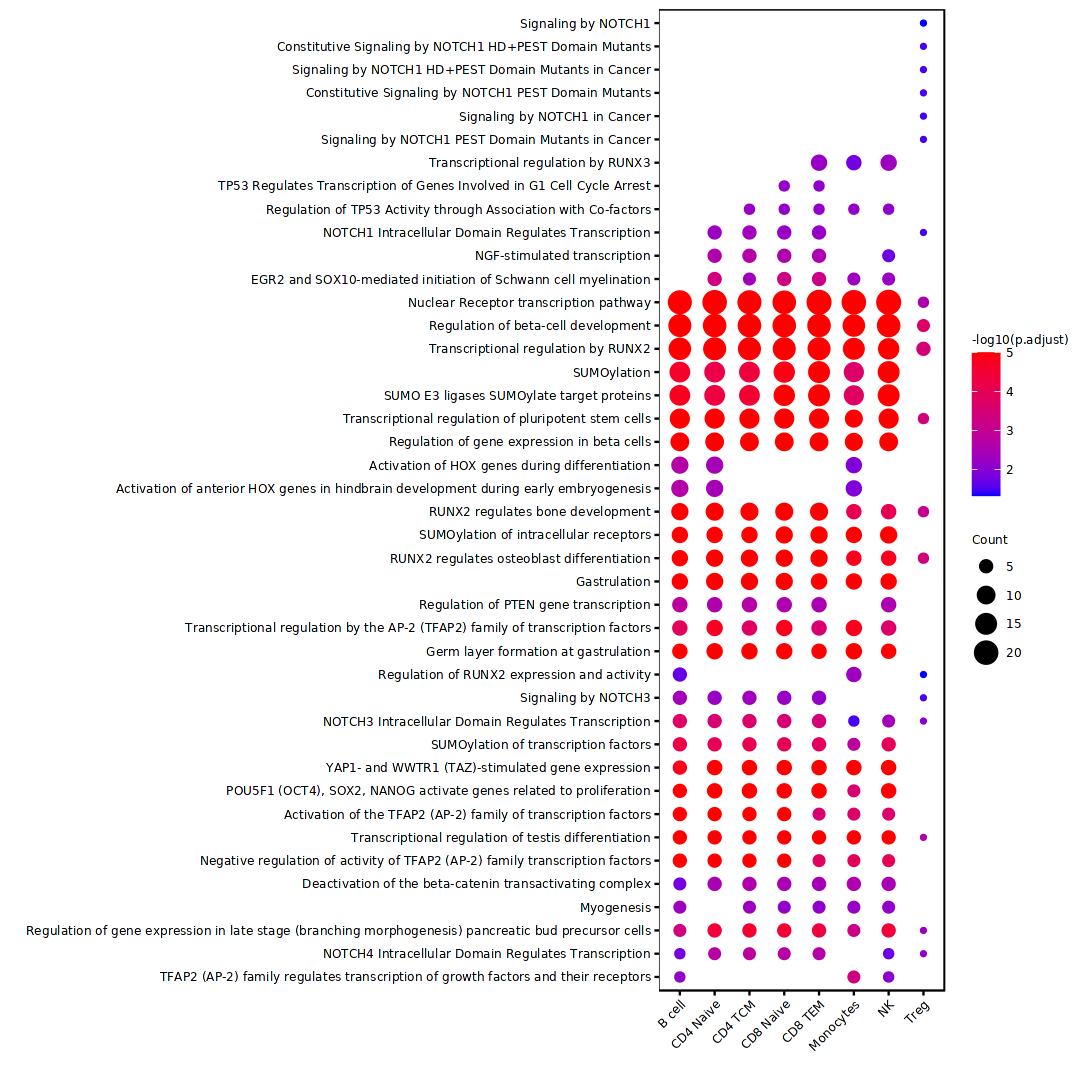

In [44]:
options(repr.plot.width = 9,repr.plot.height = 9)
p <- ggplot(df, aes(x=group, y=Description, size=Count, color=log10_p.adjust))+
    geom_point()+scale_color_gradient(low="blue",high="red", name="-log10(p.adjust)")+theme_bw()+
    ylab("")+xlab("")+plot.format+
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

p

From the above plot, we can see the 5 signature pathways are shared across cell types. Some pathways are only important in a few cell types. So we selected some representative G2 pathways and visualized below.

In [45]:
# selected pathways
selected_pathways <- c('Activation of HOX genes during differentiation','Signaling by NOTCH1 in Cancer','Transcriptional regulation by RUNX3','BMAL1:CLOCK, NPAS2 activates circadian gene expression',
                       'Deactivation of the beta-catenin transactivating complex','NOTCH3 Intracellular Domain Regulates Transcription','SUMOylation of intracellular receptors', 'YAP1- and WWTR1 (TAZ)-stimulated gene expression', 'Transcriptional regulation by RUNX2')
selected_cell_states <- c('B cell','CD4 Naive','CD4 TCM','CD8 Naive','CD8 TEM','Monocytes','NK','Treg')
df3 <- df %>% filter(Description %in% selected_pathways & group %in% selected_cell_states)
df3$Description <- factor(df3$Description, levels=selected_pathways)
head(df3)
dim(df3)

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,group,log10_p.adjust
<chr>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<dbl>
R-HSA-8878166,Transcriptional regulation by RUNX2,0.10389610,121/10899,1.151893e-11,3.824285e-10,2.861545e-10,SP7/SOX9/HAND2/NKX3-2/DLX6/GLI3/TWIST1/DLX5/HEY2/SATB2/TWIST2/HEY1/MSX2/AR/ZNF521/SMAD1,16,B cell,5.000000
R-HSA-4090294,SUMOylation of intracellular receptors,0.04545455,30/10899,1.520278e-07,2.294238e-06,1.716678e-06,NR1I2/PPARG/PGR/NR5A1/AR/NR5A2/VDR,7,B cell,5.000000
R-HSA-2032785,YAP1- and WWTR1 (TAZ)-stimulated gene expression,0.03246753,15/10899,1.413897e-06,1.564712e-05,1.170806e-05,TEAD4/NKX2-5/GATA4/TEAD1/TEAD3,5,B cell,4.805565
R-HSA-9013508,NOTCH3 Intracellular Domain Regulates Transcription,0.03246753,25/10899,2.231542e-05,1.852180e-04,1.385905e-04,HEYL/HES5/HEY2/HEY1/PBX1,5,B cell,3.732317
R-HSA-5619507,Activation of HOX genes during differentiation,0.05194805,121/10899,3.093508e-04,2.139677e-03,1.601026e-03,HOXD1/HOXA2/HOXA3/MEIS1/HOXA4/HOXA1/HOXB3/PBX1,8,B cell,2.669652
R-HSA-3769402,Deactivation of the beta-catenin transactivating complex,0.02597403,42/10899,2.826601e-03,1.617986e-02,1.210668e-02,SOX9/SOX2/SOX6/SOX13,4,B cell,1.791025


[1] 44 11

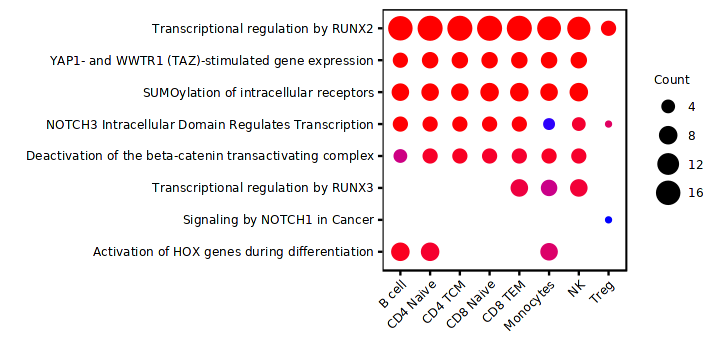

In [46]:
options(repr.plot.width = 6, repr.plot.height = 3)
p2 <- ggplot(df3, aes(x=group, y=Description, size=Count, color=p.adjust))+
    geom_point()+scale_color_gradient(low="red",high="blue", name="p.adjust")+theme_bw()+
    ylab("")+xlab("")+
    guides(color='none')+ plot.format+
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
p2

In [257]:
# save to file
pdf('summary_representative_G2_pathways_across_cell_types.pdf', width = 5, height = 2.5)
print(p2)
dev.off()

png 
  2

## top regulated genes

Now we have identified signature pathways along with involved TFs associated with RA pathogenesis. Taiji generated the regulatory network showing the regulatory relationship between TF and its target genes (**regulatee**) with edge weight, which represents the regulatory strength. Based on this, we can curate a list of representative regulatee genes by selecting the top 10 genes regulated by the signature TFs involved in each pathway ranked by the mean edge weight.

Required input: network files "/taiji_output/Network/sample*/edges_combined.csv". Each sample/pseudo-bulk cluster has one network file.

In [47]:
setwd(maindir)

In [48]:
# read signature TFs
pathways <- c('SUMOylation of intracellular receptors','Transcriptional regulation by RUNX2','YAP1- and WWTR1 (TAZ)-stimulated gene expression','Deactivation of the beta-catenin transactivating complex','NOTCH3 Intracellular Domain Regulates Transcription')
tfs <- read.csv(paste0(maindir,'kmeans/GO/G2_p0.01_d0.5_gene433_wilcoxon_GO.csv')) |> filter(Description %in% pathways) |> select(Description, p.adjust,geneID)
head(tfs)
dim(tfs)

,Description,p.adjust,geneID
,<chr>,<dbl>,<chr>
1,Transcriptional regulation by RUNX2,8.726952e-10,SP7/SOX9/NKX3-2/DLX6/HAND2/DLX5/HEY1/MSX2/ZNF521/TWIST1/TWIST2/SATB2/GLI3/AR/HEY2/HES1
2,YAP1- and WWTR1 (TAZ)-stimulated gene expression,6.966454e-07,NKX2-5/GATA4/TEAD4/TEAD1/TEAD2/TEAD3
3,SUMOylation of intracellular receptors,2.877538e-06,PGR/NR5A1/NR5A2/NR1I2/THRB/PPARG/AR
4,NOTCH3 Intracellular Domain Regulates Transcription,2.360367e-04,HEYL/HES5/HEY1/HEY2/HES1
5,Deactivation of the beta-catenin transactivating complex,2.619139e-04,SOX9/SOX2/SOX6/SOX7/TCF7L1/SOX13


[1] 5 3

In [49]:
# signature TF list
regulators <- unique(unlist(lapply(pathways, function(x) {
    r <- tfs |> filter(Description==x) |> pull(geneID) 
    strsplit(r,'/')[[1]]
})))
length(regulators)

[1] 35

In [50]:
# selected sample list
fg <- meta2 %>% filter(kmeans == 'G2' & subject.group2 == "At-Risk/ERA") %>% pull(id)
length(fg)

[1] 261

In [51]:
get_csv_file <- function(regulators, fgs, label, input_dir='/home/jupyter/output_20230310/'){

    # regulators: selected TFs
    # fgs: selected samples, in our case, the At-Risk/ERA patients
    # label: used for output file name
    # input_dir: taiji output dir
        
    read_plus <- function(x){

        dt <- fread(x)
        dt <- dt[weight>=1,] # pre-filter based on weight for acceleration
        dt <- dt[`:START_ID` %in% regulators]
        dt <- dt[,c(1:3)]
        dt$filename <- sub(".*Network/","",sub("/edges.*","",x))
        return(dt)

    }
    fl <- paste0(input_dir,"./Network/",fgs,"/edges_combined.csv")
    dt <- do.call("rbind", lapply(fl, read_plus))
    message("finished reading data")
    write.table(dt, paste0(label,"_regulatees.tsv"), quote = FALSE, row.names = FALSE)

}

In [ ]:
# this step takes ~30 min
# to save time, the output file is provided for demo purpose so that this step can be skipped
get_csv_file(regulators, fg, '35_signature_TFs_vs_all_genes')

In [52]:
dt <- read.csv('35_signature_TFs_vs_all_genes_regulatees.tsv', sep=' ')
names(dt) <- c("regulator","regulatees", "weight","sample")
dt <- dt[!grepl("[0-9]{3}", dt$regulatees),]
dt <- dt |> group_by(regulator, regulatees) |> summarise(mean_edge_weight = mean(weight))
head(dt)
dim(dt)

`summarise()` has grouped output by 'regulator'. You can override using the
`.groups` argument.


regulator,regulatees,mean_edge_weight
<chr>,<chr>,<dbl>
AR,A2M,2.249626
AR,A2M-AS1,3.017545
AR,AAAS,1.769356
AR,AAGAB,3.427286
AR,AAMP,1.208743
AR,AANAT,1.515788


[1] 77858     3

In [53]:
tfs$gene <- unlist(lapply(pathways, function(x){
    regulators <- tfs |> filter(Description==x) |> pull(geneID) 
    regulators <- strsplit(regulators,'/')[[1]]
    regulatee <- dt |> filter(regulator %in% regulators) |> group_by(regulatees) |> summarise(mean_mean_ew=mean(mean_edge_weight)) |> slice_max(mean_mean_ew, n =10) |> pull(regulatees)    
    paste0(regulatee, collapse = '/')
}))

In [370]:
head(tfs)

,Description,p.adjust,geneID,gene
,<chr>,<dbl>,<chr>,<chr>
1,Transcriptional regulation by RUNX2,8.726952e-10,SP7/SOX9/NKX3-2/DLX6/HAND2/DLX5/HEY1/MSX2/ZNF521/TWIST1/TWIST2/SATB2/GLI3/AR/HEY2/HES1,FBXL16/SPON2/KRT5/KRT6A/PPIAP40/NR2E3/MAPK8/CTSLP3/FAM99A/ZNF76
2,YAP1- and WWTR1 (TAZ)-stimulated gene expression,6.966454e-07,NKX2-5/GATA4/TEAD4/TEAD1/TEAD2/TEAD3,KRT5/TNS3/KRT6A/PPIAP40/NR2E3/FNBP1P1/CTSLP3/FAM99A/THBD/ZNF76
3,SUMOylation of intracellular receptors,2.877538e-06,PGR/NR5A1/NR5A2/NR1I2/THRB/PPARG/AR,SETD1B/DIABLO/KDM2B-DT/CAB39/FABP5/SGK1/RPTOR/EIF4ENIF1/ITPKB-IT1/KLC1
4,NOTCH3 Intracellular Domain Regulates Transcription,2.360367e-04,HEYL/HES5/HEY1/HEY2/HES1,RNY1P3/GPC6-AS1/CDADC1/CMIP/ATP8A2/EDAR/HIVEP1/SLC22A2/RPL34P6/PAICS
5,Deactivation of the beta-catenin transactivating complex,2.619139e-04,SOX9/SOX2/SOX6/SOX7/TCF7L1/SOX13,LIPG/MYO5B/MTND6P24/ANO10/TGFB1I1/C18ORF32/DYM/SNORD58C/ABCB4/SKA1


In [ ]:
write.csv(tfs, 'Table_sig_pathways_TFs_regulatees.csv')

# heatmap

In [54]:
setwd(maindir)

## top kmeans-specific TFs

In [55]:
# take the top ten TFs for each group and plot partial heatmap
L <- list.files(path = 'kmeans/', pattern = "G.*p0.01_d0.5.*txt", full.names = T)
TFs <- lapply(L, function(x) readLines(x)[1:10])
names(TFs) <- paste0("G",1:5)
annotation_row <- tibble("TF.group" = unlist(lapply(1:length(TFs), function(x) {rep(names(TFs[x]), length(TFs[[x]]))})),"TFs" = unlist(TFs))
annotation_row[annotation_row$TF.group=="G2","TFs"] <- c("ZNF304","HKR1","SP7","SP6","GLIS1","ZSCAN10","SOX9","FOXL2","CREB3L1","HEY1")
annotation_row <- annotation_row %>% tibble::column_to_rownames("TFs")
head(annotation_row)

,TF.group
,<chr>
KLF4,G1
JDP2,G1
RXRA,G1
MAFB,G1
SPI1,G1
NFE2,G1


In [57]:
get_heatmap <- function(df, info, row_ann, col_orders, mycolors){
        
    info <- info %>% dplyr::filter(id %in% colnames(df)) %>% dplyr::arrange(match(id, col_orders))
   
    # sort df make sure the order of info and df matched
    df <- df[,match(info$id,names(df))]

    annotation_col = data.frame(
      subject.group2 = info$subject.group2,
      subject.group3 = info$subject.group3,
      kmeans = info$kmeans
    )
    rownames(annotation_col) = names(df)
  
    df2 <- df[rownames(row_ann),rownames(annotation_col)]
    print(dim(df2))

    p1 <- pheatmap(df2, 
                 fontsize = 7, angle_col = 90, 
                 cellwidth = 0.2, cellheight = 7,
                 cluster_cols = F, cluster_rows = F, 
                 clustering_distance_cols = 'correlation', 
                 clustering_distance_rows = 'correlation', 
                 clustering_method = 'average',
                 annotation_row = row_ann,
                 annotation_col = annotation_col,
                 breaks = seq(-2, 4, by = 0.1),
                 show_colnames = F,
                 color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(seq(-2, 4, by = 0.1))),
                 annotation_names_row = F, annotation_names_col = F,
                 annotation_colors = mycolors, border_color = NA)
    return(p1)
}

[1]   50 1613


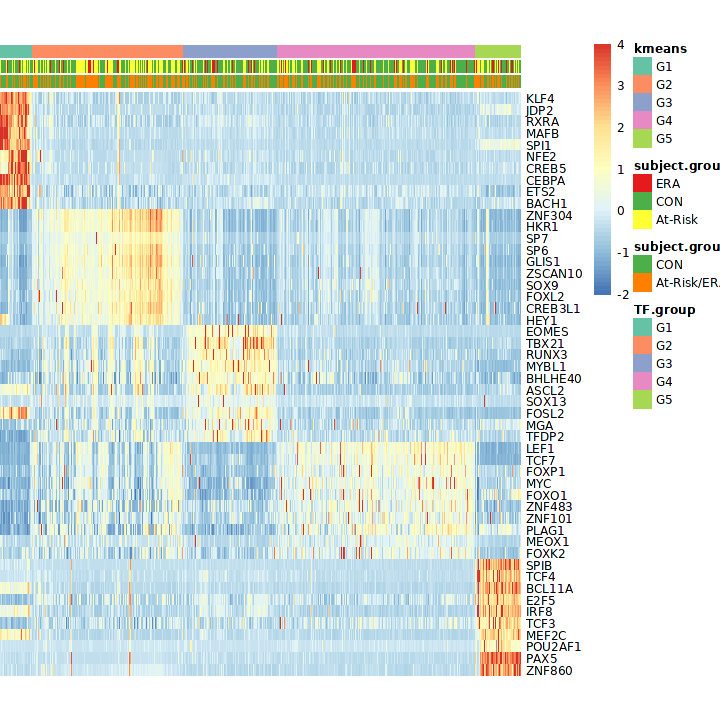

In [58]:
options(repr.plot.width=6, repr.plot.height=6)
p1 <- get_heatmap(pr_normed2, meta2, col_orders, mycolors, row_ann=annotation_row)

In [303]:
# save to file
pdf("hp_normed2_top10_TFs.pdf")
print(p1)
dev.off()

png 
  2

## all TFs

In [59]:
get_heatmap <- function(df, info, col_orders, mycolors){
        
    info <- info %>% dplyr::filter(id %in% colnames(df)) %>% dplyr::arrange(match(id, col_orders))
   
    # sort df make sure the order of info and df matched
    df <- df[,match(info$id,names(df))]

    annotation_col = data.frame(
      subject.group2 = info$subject.group2,
      subject.group3 = info$subject.group3,
      kmeans = info$kmeans
    )
    rownames(annotation_col) = names(df)
  
    p1 <- pheatmap(df, 
                 fontsize = 7, angle_col = 90, 
                 cellwidth = 0.2, cellheight = 0.2,
                 cluster_cols = F, cluster_rows = T, 
                 clustering_distance_cols = 'correlation', 
                 clustering_distance_rows = 'correlation', 
                 clustering_method = 'average',
                 annotation_col = annotation_col,
                 breaks = seq(-2, 4, by = 0.1),
                 show_colnames = F, show_rownames = F,
                 color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(seq(-2, 4, by = 0.1))),
                 annotation_names_row = F, annotation_names_col = F,
                 annotation_colors = mycolors, border_color = NA)
    return(p1)
}

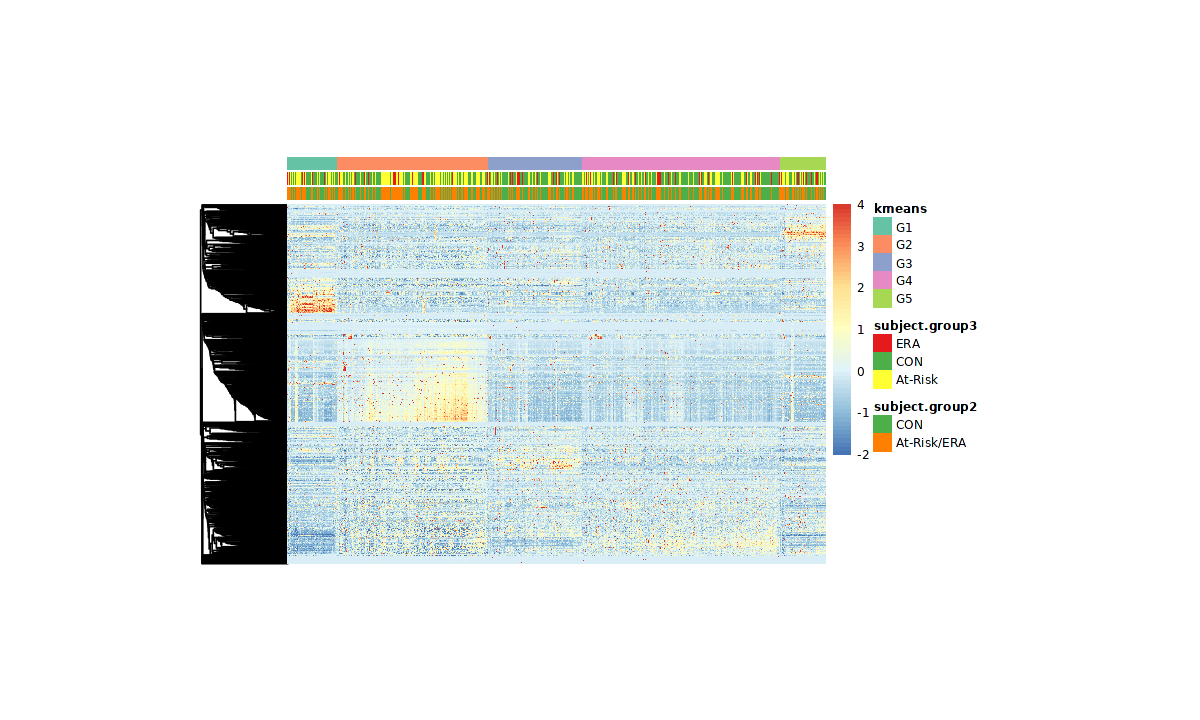

In [60]:
options(repr.plot.width=10, repr.plot.height=6)
p1 <- get_heatmap(pr_normed2, meta2, col_orders, mycolors)

In [318]:
# save to file
pdf("hp_normed2_all_TFs.pdf", height=6, width = 8)
print(p1)
dev.off()

png 
  2

## sort by cell type

In [61]:
hp_basic <- function(df,info,mycolors,...){
  
    info <- info %>% dplyr::filter(id %in% colnames(df)) %>% 
            dplyr::filter(preClust %in% selected_cell_states) %>%
            dplyr::arrange(preClust, kmeans, subject.group3)

    # sort df make sure the order of info and df matched
    df <- df[,match(info$id,names(df))]

    annotation_col = data.frame(
      cell.type = info$preClust,
      subject.group2 = info$subject.group2,
      subject.group3 = info$subject.group3,
      kmeans = info$kmeans
    )
    rownames(annotation_col) = names(df)

    p1 <- pheatmap::pheatmap(df, 
                    fontsize = 7, show_rownames = F,
                    angle_col = 90, show_colnames = F,
                    cluster_cols = F, cluster_rows = T, 
                    cellwidth = 0.3, cellheight = 0.1,
                    clustering_distance_cols = 'correlation', 
                    clustering_distance_rows = 'correlation', 
                    clustering_method = 'average',
                    annotation_col = annotation_col,
                    annotation_colors = mycolors, border_color = NA,
                    breaks = seq(-2, 4, by = 0.1),
                    color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(seq(-2, 4, by = 0.1))))
    return(p1)
  
}

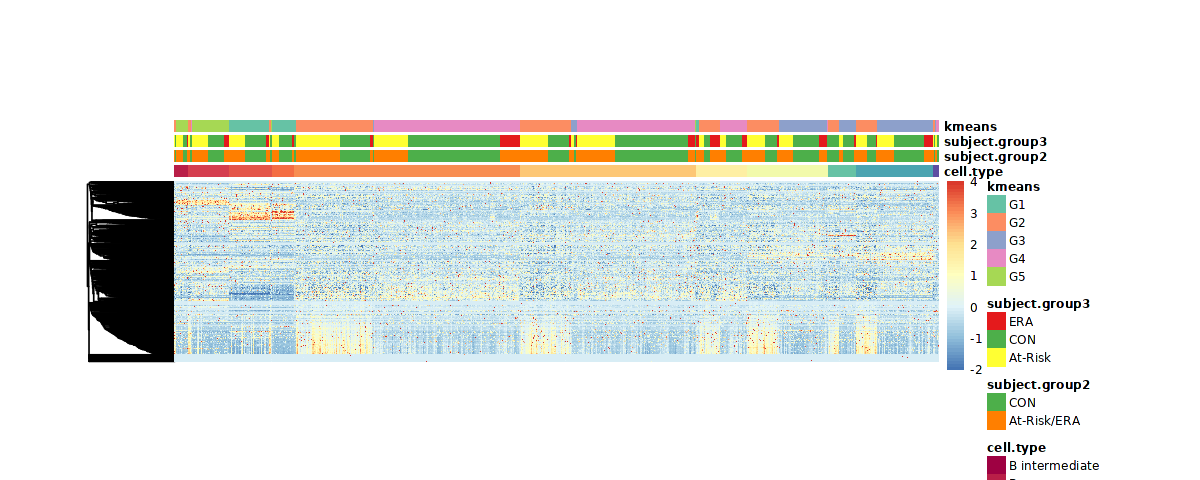

In [62]:
options(repr.plot.width=10, repr.plot.height=4)
selected_cell_states <- c("B memory", "B naive", "CD14 Mono", "CD16 Mono","CD4 Naive","CD8 Naive","CD4 TCM","CD8 TEM","MAIT","NK","Treg")
p2 <- hp_basic(pr_normed2, meta2, mycolors)

In [310]:
# save to file
pdf("hp_normed2_by_cell_type.pdf", height=10, width = 10)
print(p2)
dev.off()

png 
  2

## participants in G2 across cell states

We want to check the number of G2 clusters in each cell across At-Risk/ERA participants.

In [65]:
selected_cell_states3

[1] "B cell"    "Monocytes" "CD4 Naive" "CD4 TCM"   "CD8 Naive" "CD8 TEM"  
[7] "NK"        "Treg"

In [66]:
g2_cluster <- meta3 |> filter(RNA_cells>0) |> filter(preClust2 %in% selected_cell_states3) |> filter(kmeans=='G2') |> group_by(subject.subjectGuid, preClust2) |> summarise(n=n())
data_p <- g2_cluster |> tidyr::pivot_wider(names_from = subject.subjectGuid, values_from = n, values_fill = 0) |> tibble::column_to_rownames('preClust2')

`summarise()` has grouped output by 'subject.subjectGuid'. You can override
using the `.groups` argument.


In [67]:
# reorganize it by disease state
meta_p <- meta3 |> distinct(subject.subjectGuid, subject.group3) |> arrange(factor(subject.group3, levels = c('ERA', 'At-Risk','CON'))) 
ss <- meta_p |> pull(subject.subjectGuid)
data_p <- data_p[,intersect(ss, names(data_p))]
meta_p <- meta_p |> tibble::column_to_rownames('subject.subjectGuid')

In [68]:
# only non-CON groups with rows clustered
colors = list(subject.group3 = c('#E41A1C','#4DAF4A','#FFFF33'))
names(colors$subject.group3) = c("ERA","CON","At-Risk")

meta_ps <- meta_p |> filter(!subject.group3=='CON')
data_ps <- data_p[,rownames(meta_ps)]
p1 <- pheatmap::pheatmap(data_ps, filename = 'hp_cell_type_across_patients_noMAIT_noCON_row_clustered.pdf', 
                         cellheight = 7, fontsize = 7, cellwidth = 7, 
                         cluster_cols = F, cluster_rows = T,
                         # color = colorRampPalette(rev(brewer.pal(n = 9, name = "RdYlBu")))(length(breaksList)),
                         # breaks = breaksList,
                         annotation_names_col = FALSE, show_colnames=FALSE,
                         annotation_col=meta_ps, annotation_colors=colors
                        )

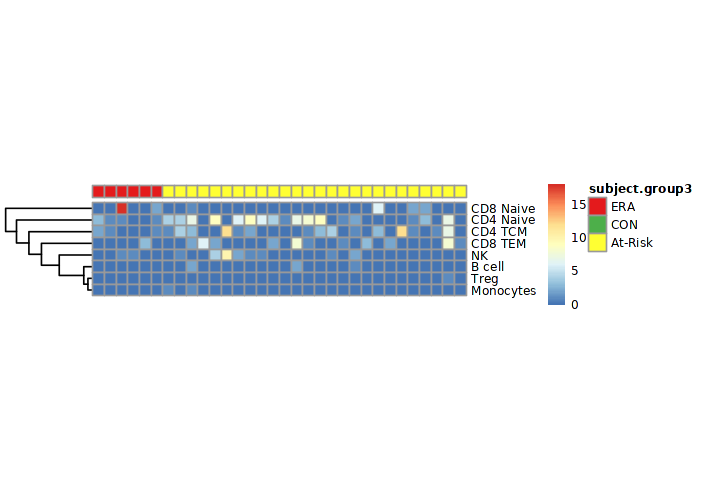

In [69]:
options(repr.plot.width=6, repr.plot.height=4)
print(p1)

In [341]:
# save to file
pdf("hp_n_clusters_cell_type_across_patients.pdf", height=2, width = 6)
print(p1)
dev.off()

png 
  2

## top signature TFs across cell types

We selected top 40 G2-specific TFs to visualize the mean PageRank scores

In [70]:
TFs <- readLines(paste0(maindir,'kmeans/G2_p0.01_d0.5_gene433_wilcoxon.txt'))[1:100]
TFs

[1] "ZNF304"  "SP9"     "HKR1"    "WT1"     "LHX8"    "SP5"     "TFAP2C" 
  [8] "PAX7"    "TFAP2B"  "SP7"     "RBPJL"   "SPZ1"    "KLF17"   "PAX4"   
 [15] "ETV4"    "ZIC1"    "NKX2-5"  "TFDP3"   "SP6"     "GLIS1"   "RXRG"   
 [22] "ZSCAN10" "IRX1"    "VSX2"    "NFE4"    "CTCFL"   "FOXN1"   "ETV3L"  
 [29] "ZNF254"  "RFX6"    "ZFP42"   "SIX1"    "EGR4"    "EN2"     "ZIC2"   
 [36] "NHLH2"   "BNC1"    "ONECUT1" "TFAP2D"  "GBX1"    "FOXN4"   "TBX4"   
 [43] "BARHL2"  "OVOL1"   "NOTO"    "LHX9"    "SOX9"    "PTF1A"   "EN1"    
 [50] "VAX2"    "SPDEF"   "SOX2"    "TBX20"   "FOXL2"   "GATA4"   "PKNOX2" 
 [57] "ZNF479"  "PRDM14"  "INSM1"   "GLIS2"   "ONECUT2" "ZNF534"  "FOXD3"  
 [64] "VSX1"    "POU3F3"  "PROP1"   "LHX6"    "EBF2"    "NR2F1"   "SALL4"  
 [71] "BARHL1"  "NOBOX"   "IRX4"    "SOHLH2"  "KLF14"   "CREB3L1" "NKX2-1" 
 [78] "FOXG1"   "ZNF705G" "EMX1"    "BCL6B"   "PRRX1"   "HOXA13"  "SCRT2"  
 [85] "NEUROD1" "MYOG"    "PHOX2A"  "FOXD4L3" "VAX1"    "FOXE1"   "FOXD4L6"
 [92] "FOXE3"   "HAND1"   "TBX2"    "HOXD1"   "FOXD4L4" "HEYL"    "NR0B1"  
 [99] "CDX1"    "LHX2"

In [71]:
info <- meta2 %>% mutate(kmeans2 = ifelse(kmeans=="G2", 'G2', "other"))
df <- pr_normed2[TFs,] |> tibble::rownames_to_column('TF') |> tidyr::pivot_longer(cols = !TF,names_to = 'id', values_to = 'value')
df1 <- info %>% dplyr::inner_join(df, by = "id") %>% dplyr::group_by(preClust, TF, kmeans2) %>% dplyr::summarise(mean.value=mean(value)) |> ungroup() |> 
    filter(preClust %in% selected_cell_states) |> dplyr::mutate(group=paste0(preClust,'_',kmeans2))
head(df1)
dim(df1)

`summarise()` has grouped output by 'preClust', 'TF'. You can override using
the `.groups` argument.


preClust,TF,kmeans2,mean.value,group
<chr>,<chr>,<chr>,<dbl>,<chr>
B memory,BARHL1,G2,-0.02293359,B memory_G2
B memory,BARHL1,other,-0.02757569,B memory_other
B memory,BARHL2,G2,-0.02183471,B memory_G2
B memory,BARHL2,other,-0.02868451,B memory_other
B memory,BCL6B,G2,0.97218524,B memory_G2
B memory,BCL6B,other,-0.74843732,B memory_other


[1] 2200    5

In [72]:
# second round filtering: diff(G2-other)>0.5
TFs2 <- df1 |> dplyr::group_by(TF, kmeans2) |> dplyr::summarise(mean2.value=mean(mean.value)) |> 
    tidyr::pivot_wider(names_from = kmeans2, values_from = mean2.value) |> mutate(diff=G2-other) |> filter(diff>0.5) |> pull(TF)

`summarise()` has grouped output by 'TF'. You can override using the `.groups`
argument.


In [74]:
m <- df1 |> filter(TF %in% TFs2) |> select(TF, mean.value, group) |> tidyr::pivot_wider(names_from = group, values_from = mean.value) %>% tibble::column_to_rownames("TF")
m <- m[,c(paste0(selected_cell_states,'_G2'), paste0(selected_cell_states,'_other'))]
head(m)
dim(m)

,B memory_G2,B naive_G2,CD14 Mono_G2,CD16 Mono_G2,CD4 Naive_G2,CD8 Naive_G2,CD4 TCM_G2,CD8 TEM_G2,MAIT_G2,NK_G2,⋯,B naive_other,CD14 Mono_other,CD16 Mono_other,CD4 Naive_other,CD8 Naive_other,CD4 TCM_other,CD8 TEM_other,MAIT_other,NK_other,Treg_other
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BCL6B,0.9721852,2.000205,2.7242775,0.6955235,1.1804733,0.9362827,0.8401285,1.2363000,0.8269661,1.3810863,⋯,-0.4783481,-0.3658342,-0.8008889,-0.2816554,-0.21596709,-0.4008575,-0.5693812,-0.6813388,-0.5417387,-0.6566006
CDX1,0.6431257,1.526280,2.1907696,0.9016540,1.0806949,0.8296318,0.6777565,0.8033439,0.5015048,0.9400020,⋯,-0.6260708,-0.4630581,-0.6825702,-0.1270578,-0.01100533,-0.2975312,-0.5348990,-0.6371703,-0.5130237,-0.5746345
CREB3L1,1.2751081,1.804800,1.9208919,0.1317820,1.0787990,1.0845737,0.8382501,1.1492643,1.2874642,1.4081378,⋯,-0.5694747,-0.5114189,-0.8636008,-0.2949172,-0.06261530,-0.3659071,-0.5266983,-0.6460616,-0.5162935,-0.5809875
CTCFL,1.1795735,1.834711,2.0459851,0.1818167,1.2320209,0.9998697,0.8902160,1.1285350,1.2481099,1.5022693,⋯,-0.6947228,-0.5873194,-0.9179527,-0.3062874,-0.09231374,-0.3555757,-0.5402887,-0.6013103,-0.5896293,-0.3220032
EGR4,1.2436265,1.841428,1.9505265,0.1732466,1.0710402,0.9974195,0.9759224,1.2699157,1.2541103,1.3812948,⋯,-0.7843901,-0.5719126,-0.7732131,-0.2815199,-0.12779031,-0.4182349,-0.5176985,-0.4904381,-0.5435982,0.1380586
EMX1,0.4732495,1.176148,0.9903059,0.2269356,0.6203997,0.6690940,0.4545887,1.1341384,0.4495893,0.8518043,⋯,-0.3758504,-0.1221316,-0.4612262,-0.2046859,-0.16022540,-0.2771355,-0.2199217,-0.3784120,-0.3125657,-0.2095281


[1] 35 22

In [75]:
# set annotation 
annotation_col <- df1 |> distinct(kmeans2, group) |> tibble::column_to_rownames("group")

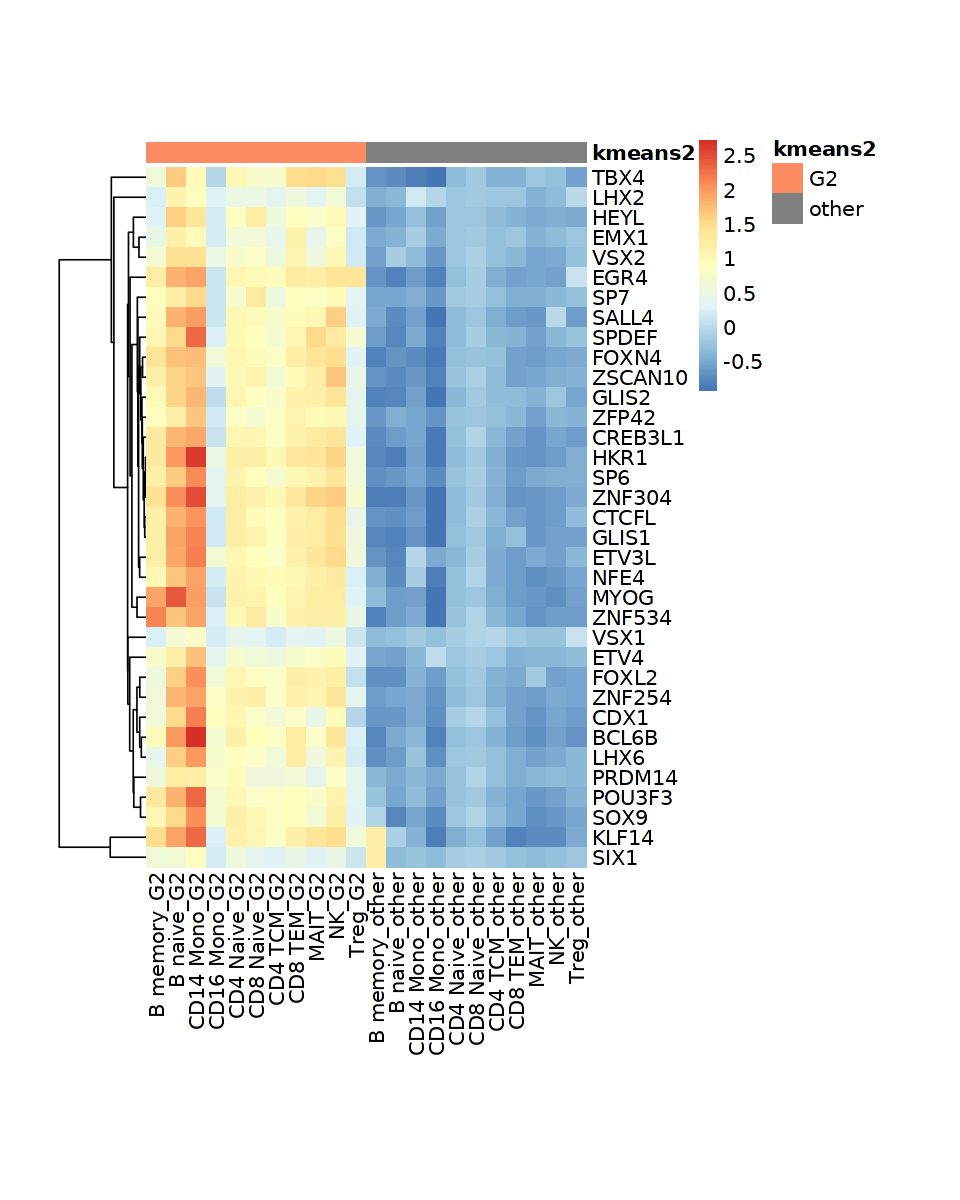

In [76]:
options(repr.plot.width=8, repr.plot.height=10)
p <- pheatmap::pheatmap(m, 
                fontsize = 12, show_rownames = T,
                angle_col = 90, show_colnames = T,
                cluster_cols = F, cluster_rows = T, 
                cellwidth = 12, cellheight = 12,
                clustering_distance_cols = 'correlation', 
                clustering_distance_rows = 'correlation', 
                clustering_method = 'average',
                annotation_col = annotation_col, 
                annotation_colors = mycolors,
                border_color = NA,
                filename = NA)

# session info

In [77]:
sessionInfo()

R version 4.2.2 Patched (2022-11-10 r83330)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] UpSetR_1.4.0          factoextra_1.0.7      data.table_1.14.6    
 [4] pheatmap_1.0.12       dplyr_1.1.4           ggplot2_3.4.4        
 [7] RColorBrewer_1.1-3    ReactomePA_1.42.0     enrichplot_1.18.4    
[10] clusterProfiler_4.6.2 org.Hs.eg.db_3.16.0   AnnotationDbi_1.60.0 